In [32]:
from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [33]:
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# What is a radiation belt electron enhancement event?

## Introduction to the problem

The Earth's outer electron radiation belt is a very dynamic region in which fluxes in the hundreds of keV up to tens of MeV can vary several orders of magnitude in periods that range from a few minutes up to a few days. One of the most common processes associated with this extreme dynamics of the outer radiation belt is the enhancement of electron fluxes at relativistic or ultrarelativistic energies, in which geomagnetic activity sets in motion a series of internal processes of transport, losses and acceleration of electrons that can lead to "enhanced levels" in fluxes. This problem is of much interest for the scientific community as it has practical applications (for example, it is known that enhanced fluxes can damage instruments in satellites, most of which reside inside the outer radiation belt), but despite many advances in the past years, it is still not completely understood. 

Although relativistic electron enhancements are frequently discussed and studied, few attempts have been made to characterize the "baseline" values that should be used to describe them. Most of current works adopt a definition for an enhancement event based on the work by Reeves [_Reeves et al. [2003]_](http://onlinelibrary.wiley.com/doi/10.1029/2002GL016513/abstract) definition (an enhancement event occurs when flux is  twice the flux of pre-storm) which consider flux variations around a geomagnetic storm and defines an enhancement when the fluxes at least duplicate its value after the storm. This definition was initially presented to be used at geostationary orbit, but has since been expanded to the rest of the radiation belt. Similarly, the National Oceanic and Atmospheric Administration [NOAA](http://www.swpc.noaa.gov/products/goes-electron-flux) issues warning when the >2 MeV fluxes at geostationary orbit are higher than 1000 cm$^{-2}$ sr$^{-1}$ s$^{-1}$ (from now on referred as flux units or FU) 

Each method has its benefits but also several limitations; primarily, a characterization of the typical values of the radiation belt electron fluxes has not been performed using in-situ equatorial measurements and therefore, we don't know what the radiation baseline should be at different L-shells. Also, relativistic electron enhancement events occur regularly in association with "no storm-time" and just considering a double in flux values can lead to results in which extremely low flux levels at a particular L-shell apprar to be "enhanced" but very unlikely represent a threat.

The objective of this work is to establish a criteria to what a radiation belt electron enhancement event should be, based on the determination of a "baseline" for fluxes in the radiation belts. To do that, we will use data from the REPT instrument onboard the Van Allen Probes to characterize the typical electron flux values across the outer radiation belt. 

## Objective

By analyzing Van Allen Probes REPT data between September 2012 and December 2018, determine the statistical values of relativistic electron fluxes at different L-shells in order to come up with a definition of electron enhancement events that is L-dependent

## Data pre-processing

Starting from REPT L3 data (sampled at 11 seconds) I have created a dataset with electron fluxes, l-values, mlt, and time. Pre-processing was done in IDL by doing:

+ Average FEDU (pitch angle distribution) in order to create omnidirectional values (FEDO).
+ Create an L-grid from L=2.5 to L=6.6
+ Average all the measurements in a particular [L,L+0.1]. Time is determined as the center time of all measurements. MLT is determined as average MLT value of all measurements. I have done this by averaging all fluxes and then taking the average(log(fluxes)).
+ Additionally, I created a L-T binning using $\Delta L$ = 0.1 and $\Delta T$ = 6 hours also in two ways average(log(flux))
+ Three datasets have been produced. RBSP-A only, RBSP-B only, and a dataset that merges both (and sorts by time).

## Reading the data (in this Jupyter notebook)

We have calculated the FEDO L-binned (and L-T binned) for the whole duration of the Van Allen Probes mission (September 2012 to July 2019). We stored the data in monthly-length files and here we proceed to load it back in a Pandas DataFrame. 

A simple description of the dataframes shows that the merged files contains 939k measurements, with A having 472k and B 467k. There is not a significant difference in the datasets, but it can be seen that fluxes from RBSP-A are 15% - 20% higher than the fluxes from RBSP-B. We will perform (at least for now) three analysis; one for the merged files, and one for the individual satellites. 

TODO: Explore the consistency of RBSPA fluxes being larger than RBSPB fluxes

In [34]:
%matplotlib inline

import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
#import powerlaw

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


unix_time = dt.date(1971,1,1).toordinal()*24*60*60

In [35]:
def plotOptions():
    """
    Defines the most general characteristics for the plots in 
    this notebook. 
    :label size for x and y axis
    :linewidth for the frame
    """
    plt.tick_params(axis='x', labelsize='14')
    plt.tick_params(axis='y', labelsize='14')
    for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(1.2)
    
def axhlines(ys, ax=None, **plot_kwargs):
    """
    Draw horizontal lines across plot
    :param ys: A scalar, list, or 1D array of vertical offsets
    :param ax: The axis (or none to use gca)
    :param plot_kwargs: Keyword arguments to be passed to plot
    :return: The plot object corresponding to the lines.
    """
    if ax is None:
        ax = plt.gca()
    ys = np.array((ys, ) if np.isscalar(ys) else ys, copy=False)
    lims = ax.get_xlim()
    y_points = np.repeat(ys[:, None], repeats=3, axis=1).flatten()
    x_points = np.repeat(np.array(lims + (np.nan, ))[None, :], repeats=len(ys), axis=0).flatten()
    plot = ax.plot(x_points, y_points, scalex = False, **plot_kwargs)
    return plot

def axvlines(xs, ax=None, **plot_kwargs):
    """
    Draw vertical lines on plot
    :param xs: A scalar, list, or 1D array of horizontal offsets
    :param ax: The axis (or none to use gca)
    :param plot_kwargs: Keyword arguments to be passed to plot
    :return: The plot object corresponding to the lines.
    """
    if ax is None:
        ax = plt.gca()
    xs = np.array((xs, ) if np.isscalar(xs) else xs, copy=False)
    lims = ax.get_ylim()
    x_points = np.repeat(xs[:, None], repeats=3, axis=1).flatten()
    y_points = np.repeat(np.array(lims + (np.nan, ))[None, :], repeats=len(xs), axis=0).flatten()
    plot = ax.plot(x_points, y_points, scaley = False, **plot_kwargs)
    return plot

In [36]:
#dataDir = 'D:/data/rbsp/compressed-rept-l-binned-L66/'
dataDir = '/Users/Victor/OneDrive/Research/current/rb-characterization/data/compressed-rept-l-binned-L66/'
files = glob.glob(dataDir+'merged_fedo_rept_*.dat')
filesa = glob.glob(dataDir+'rbspa_fedo_rept_*.dat')
filesb = glob.glob(dataDir+'rbspb_fedo_rept_*.dat')

f = []
a = []
b = []

head = ['epoch', 'L', 'MLT', 'E18', 'E21', 'E26', 'E34', 'E42', 'E52', 'E63', 'E72']

for fil in files:
    df = pd.read_csv(fil, delim_whitespace=True, header=None)
    f.append(df)

for fil in filesa:
    df = pd.read_csv(fil, delim_whitespace=True, header=None)
    a.append(df)

for fil in filesb:
    df = pd.read_csv(fil, delim_whitespace=True, header=None)
    b.append(df)
    
rbaData = pd.concat(a, axis = 0, ignore_index = True)
rbaData.columns = head
rbaData.at[rbaData.MLT >= 24 , 'MLT'] = 0
rbaData['pdDate'] = pd.to_datetime(rbaData.epoch/1000-unix_time, unit='s')
rbaData.index = pd.to_datetime(rbaData.epoch/1000-unix_time, unit='s')

rbbData = pd.concat(b, axis = 0, ignore_index = True)
rbbData.columns = head
rbbData.at[rbbData.MLT >= 24 , 'MLT'] = 0
rbbData['pdDate'] = pd.to_datetime(rbbData.epoch/1000-unix_time, unit='s')
rbbData.index = pd.to_datetime(rbbData.epoch/1000-unix_time, unit='s')

rbData = pd.concat(f, axis = 0, ignore_index = True)
rbData.columns = head
rbData.at[rbData.MLT >= 24 , 'MLT'] = 0
rbData['pdDate'] = pd.to_datetime(rbData.epoch/1000-unix_time, unit='s')
rbData.index = pd.to_datetime(rbData.epoch/1000-unix_time, unit='s')

lArray = rbData['L'].unique()
lArray.sort()
mltArray = rbData['MLT'].apply(np.floor).unique()
mltArray.sort()

rbData.describe()
#rbaData.describe()
#rbbData.describe()

,epoch,L,MLT,E18,E21,E26,E34,E42,E52,E63,E72
count,9.710730e+05,971073.000000,971073.000000,9.704700e+05,9.704700e+05,9.704700e+05,970470.000000,970470.000000,970470.000000,970469.000000,970465.000000
mean,6.362233e+13,4.274420,12.081681,2.638649e+05,1.025193e+05,3.506670e+04,8651.056505,1692.528917,419.842924,50.234235,4.816007
std,6.279944e+10,1.063348,7.132201,6.811106e+05,2.651391e+05,1.045957e+05,30928.627110,7292.684924,2228.000582,272.668150,9.421598
min,6.351372e+13,2.500000,0.000000,8.650100e+00,3.717700e+00,1.700900e+00,1.287600,0.000000,1.044100,0.891900,0.000000
25%,6.356829e+13,3.400000,5.620000,1.582176e+03,6.808167e+02,1.922396e+02,31.888075,5.805500,4.124100,3.645000,2.928100
50%,6.362298e+13,4.300000,12.250000,3.009312e+04,1.078037e+04,2.622138e+03,393.715300,47.680750,9.660200,4.929100,3.446900
75%,6.367686e+13,5.200000,18.410000,2.037238e+05,7.530513e+04,1.997396e+04,3408.968750,445.687975,73.236375,10.508800,4.143000
max,6.373184e+13,6.600000,23.990000,1.306152e+07,4.857521e+06,2.276739e+06,868530.065000,268692.086100,113792.296300,14482.508600,856.088700


# Spatial distribution of measurements and flux values

## L measurements and MLT measurements

Let's start by doing some counting. Figure below shows the distribution of single (each spacecraft) and combined measurements as a function of L-shell (up) and MLT (down). We can observe that the number of measurements is realtively constant in the region $2.5 < L <  5.5$ and then decrease for higher $L$-shells. This is product of the satellite having an apogee at $5.8 R_E$ which combined with an inclination of around $10^\circ$ allows the satellite to reach higher L-shells, but not consistenly. Still, the measurements at $L=6.0$ are at a healthy 15.000 counts when combined which corresponds to roughly a $60\%$ of the 25000 counts at lower $L$-shells. The MLT distribution has a preference for post and pre-midnight values, and a minium at around noon. The difference here being the lower counts corresponding roughly to a $80\%$ of the maximum counts.

Note that since we expanded to the region $6.0 < L < 6.6$ it is much clear how the measurements as a function of L start to decrease as we get past $L > 5.8$. In principle, statistics at higher L should not be blindly trusted, but hopefully we can at least get some relevant information, for comparison with GOES satellite data. 

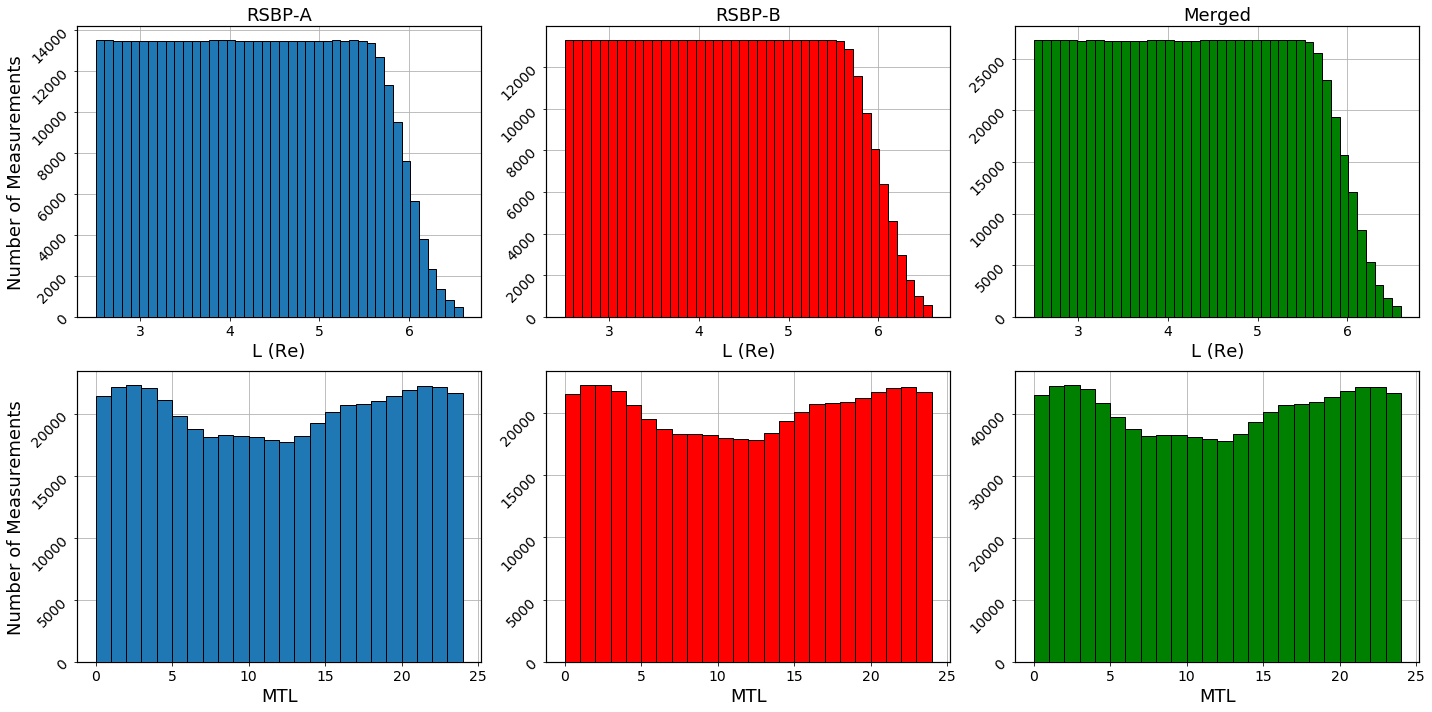

In [37]:
#plot histogram of occurrence for L and MLT    
    
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(231)
plotOptions()
plt.xlabel('L (Re)', fontsize='18')
plt.ylabel('Number of Measurements',fontsize='18')
plt.title('RSBP-A',fontsize='18')
plt.xrange=(lArray[0],lArray[-1])
rbaData.L.hist(alpha=1, bins=len(lArray), edgecolor='black', range=(lArray[0],lArray[-1]), zorder=3, yrot=45)

ax = fig.add_subplot(232)
plotOptions()
plt.xlabel('L (Re)', fontsize='18')
plt.title('RSBP-B',fontsize='18')
plt.xrange=(lArray[0],lArray[-1])
rbbData.L.hist(alpha=1, bins=len(lArray), edgecolor='black', range=(lArray[0],lArray[-1]), zorder=3, yrot=45, color='red')

ax = fig.add_subplot(233)
plotOptions()
plt.xlabel('L (Re)', fontsize='18')
plt.title('Merged',fontsize='18')
plt.xrange=(lArray[0],lArray[-1])
rbData.L.hist(alpha=1, bins=len(lArray), edgecolor='black', range=(lArray[0],lArray[-1]), zorder=3, yrot=45, color='green')

ax = fig.add_subplot(234)
plotOptions()
plt.ylabel('Number of Measurements',fontsize='18')
plt.xlabel('MTL', fontsize='18')
rbaData.MLT.hist(alpha=1, bins=24, edgecolor='black', range=(0,24), zorder =3, yrot=45)

ax = fig.add_subplot(235)
plotOptions()
plt.xlabel('MTL', fontsize='18')
rbbData.MLT.hist(alpha=1, bins=24, edgecolor='black', range=(0,24), zorder =3, yrot=45, color='red')

ax = fig.add_subplot(236)
plotOptions()
plt.xlabel('MTL', fontsize='18')
rbData.MLT.hist(alpha=1, bins=24, edgecolor='black', range=(0,24), zorder =3, yrot=45, color='green')


plt.tight_layout()
plt.show()

## L-MLT measurements

If we now look at each bin separately, we can appreciate that the distribution of datapoints is relatively homogeneus for $L < 5.5$, although the orbital effect is shown as dayside MLT have less measurements. At higher $L > 5.8$ the number of measurements drop really fast at $6 < MLT < 18$ compared to the near midnight sector. At the night sector the number of measurements is relatively independent of L-shell and MLT for $L < 6.0$. 

General lower number of measurements in the dayside are associated with the fact that the satellites covered the whole MLT range every 2 years, and therefore there were only ~3.5 rotations total. 

To perform statistics, we have that with the exception of high-L dayside, there are around 1000 measurements in each bin of 1 MLT and 0.1 L. We also need to consider that when dealing with ultra-relativistic electrons, the short period of drift around the Earth (< 10 minutes) should signify that there is no significant dependence of MLT flux values and that any difference, in case they exist should be associated with the time of those measurements.  

In [38]:
rbData['E21log'] = np.log10(rbData.E21)
rbaData['E21log'] = np.log10(rbaData.E21)
rbbData['E21log'] = np.log10(rbbData.E21)

In [39]:
binOccurrence = np.zeros((24,len(lArray)))
binFluxAvg = np.zeros((24,len(lArray)))
binFluxMedian = np.zeros((24,len(lArray)))

binOccurrenceA = np.zeros((24,len(lArray)))
binFluxAvgA = np.zeros((24,len(lArray)))
binFluxMedianA = np.zeros((24,len(lArray)))

binOccurrenceB = np.zeros((24,len(lArray)))
binFluxAvgB = np.zeros((24,len(lArray)))
binFluxMedianB = np.zeros((24,len(lArray)))


for l in range(len(lArray)):
    for mlt in range(len(mltArray)):
        binOccurrence[mlt,l] = sum(rbData.L[(rbData.MLT >= mltArray[mlt]) & (rbData.MLT < mltArray[mlt]+1)] == lArray[l])*1
        binFluxAvg[mlt,l] = rbData.E21log[(rbData.MLT >= mltArray[mlt]) & (rbData.MLT < mltArray[mlt]+1) & (rbData.L == lArray[l])].mean()
        binFluxMedian[mlt,l] = rbData.E21log[(rbData.MLT >= mltArray[mlt]) & (rbData.MLT < mltArray[mlt]+1) & (rbData.L == lArray[l])].median()
        
        binOccurrenceA[mlt,l] = sum(rbaData.L[(rbaData.MLT >= mltArray[mlt]) & (rbaData.MLT < mltArray[mlt]+1)] == lArray[l])*1
        binFluxAvgA[mlt,l] = rbaData.E21log[(rbaData.MLT >= mltArray[mlt]) & (rbaData.MLT < mltArray[mlt]+1) & (rbaData.L == lArray[l])].mean()
        binFluxMedianA[mlt,l] = rbaData.E21log[(rbaData.MLT >= mltArray[mlt]) & (rbaData.MLT < mltArray[mlt]+1) & (rbaData.L == lArray[l])].median()
        
        binOccurrenceB[mlt,l] = sum(rbbData.L[(rbbData.MLT >= mltArray[mlt]) & (rbbData.MLT < mltArray[mlt]+1)] == lArray[l])*1
        binFluxAvgB[mlt,l] = rbbData.E21log[(rbbData.MLT >= mltArray[mlt]) & (rbbData.MLT < mltArray[mlt]+1) & (rbbData.L == lArray[l])].mean()
        binFluxMedianB[mlt,l] = rbbData.E21log[(rbbData.MLT >= mltArray[mlt]) & (rbbData.MLT < mltArray[mlt]+1) & (rbbData.L == lArray[l])].median()

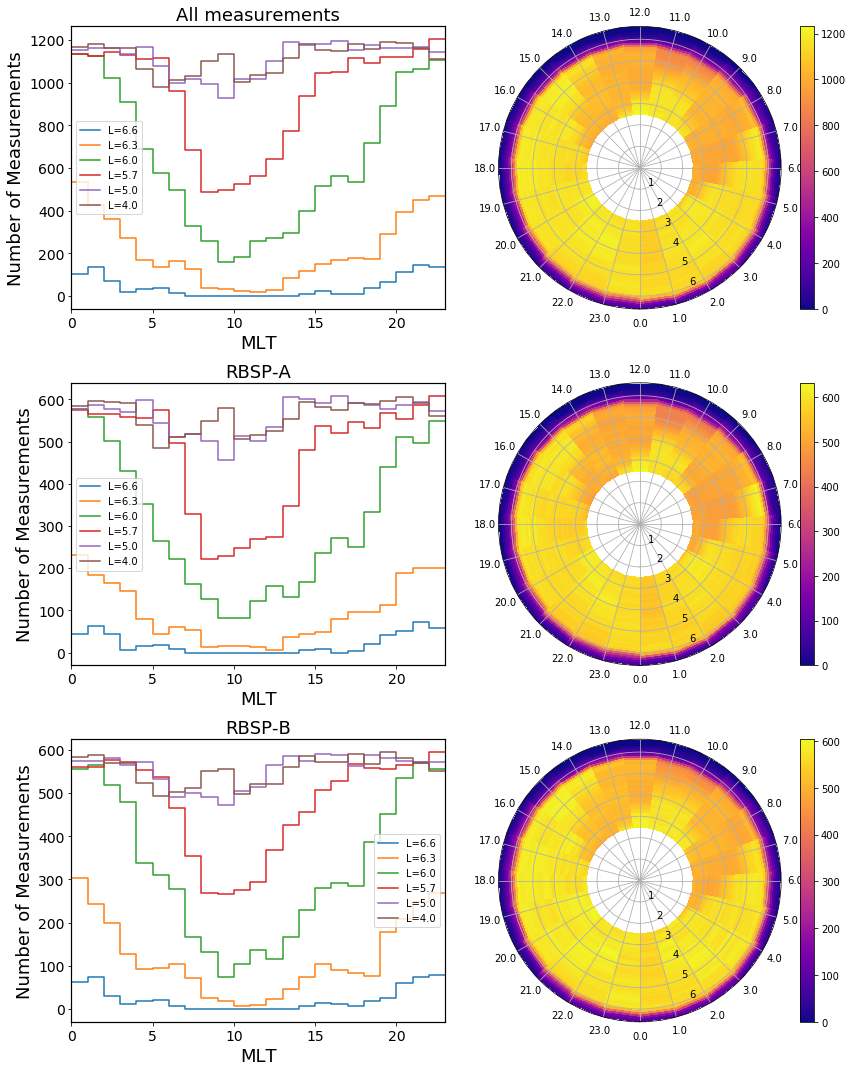

In [40]:
#plot occurrence for L and MLT in grid

rad = lArray
azm = np.asarray(mltArray)/23.*2*np.pi
r, th = np.meshgrid(rad, azm)
cm2 = plt.cm.get_cmap('plasma')

fig = plt.figure(figsize=(12,15))

ax = fig.add_subplot(321)
plotOptions()
plt.xlim(0,23)
plt.xlabel('MLT', fontsize='18')
plt.ylabel('Number of Measurements', fontsize='18')
plt.title('All measurements', fontsize='18')
plt.step(mltArray, binOccurrence[:,41], label = 'L=6.6')
plt.step(mltArray, binOccurrence[:,38], label = 'L=6.3')
plt.step(mltArray, binOccurrence[:,35], label = 'L=6.0')
plt.step(mltArray, binOccurrence[:,33], label = 'L=5.7')
plt.step(mltArray, binOccurrence[:,25], label = 'L=5.0')
plt.step(mltArray, binOccurrence[:,15], label = 'L=4.0')
plt.legend()

ax = fig.add_subplot(322, projection='polar')
ax.set_theta_offset(np.pi*3/2)
plt.pcolormesh(th, r, binOccurrence, cmap=cm2)
plt.plot(azm, r, ls='none')
plt.grid()
plt.thetagrids([theta * 15 for theta in range(360//15)], labels=mltArray)
plt.colorbar(aspect=20, fraction=0.08)


ax = fig.add_subplot(323)
plotOptions()
plt.xlim(0,23)
plt.xlabel('MLT', fontsize='18')
plt.ylabel('Number of Measurements', fontsize='18')
plt.title('RBSP-A', fontsize='18')
plt.step(mltArray, binOccurrenceA[:,41], label = 'L=6.6')
plt.step(mltArray, binOccurrenceA[:,38], label = 'L=6.3')
plt.step(mltArray, binOccurrenceA[:,35], label = 'L=6.0')
plt.step(mltArray, binOccurrenceA[:,33], label = 'L=5.7')
plt.step(mltArray, binOccurrenceA[:,25], label = 'L=5.0')
plt.step(mltArray, binOccurrenceA[:,15], label = 'L=4.0')
plt.legend()

ax = fig.add_subplot(324, projection='polar')
ax.set_theta_offset(np.pi*3/2)
plt.pcolormesh(th, r, binOccurrenceA, cmap=cm2)
plt.plot(azm, r, ls='none')
plt.grid()
plt.thetagrids([theta * 15 for theta in range(360//15)], labels=mltArray)
plt.colorbar(aspect=20, fraction=0.08)

ax = fig.add_subplot(325)
plotOptions()
plt.xlim(0,23)
plt.xlabel('MLT', fontsize='18')
plt.ylabel('Number of Measurements', fontsize='18')
plt.title('RBSP-B', fontsize='18')
plt.step(mltArray, binOccurrenceB[:,41], label = 'L=6.6')
plt.step(mltArray, binOccurrenceB[:,38], label = 'L=6.3')
plt.step(mltArray, binOccurrenceB[:,35], label = 'L=6.0')
plt.step(mltArray, binOccurrenceB[:,33], label = 'L=5.7')
plt.step(mltArray, binOccurrenceB[:,25], label = 'L=5.0')
plt.step(mltArray, binOccurrenceB[:,15], label = 'L=4.0')
plt.legend()

ax = fig.add_subplot(326, projection='polar')
ax.set_theta_offset(np.pi*3/2)
plt.pcolormesh(th, r, binOccurrenceB, cmap=cm2)
plt.plot(azm, r, ls='none')
plt.grid()
plt.thetagrids([theta * 15 for theta in range(360//15)], labels=mltArray)
plt.colorbar(aspect=20, fraction=0.08)


plt.tight_layout()
plt.show()

## Flux distribution (histogram) for fixed L

A look at the distribution of fluxes for $E = 2.1$ MeV electrons at different (fixed) $L$-shells for all MLT measurements reveals that the highest fluxes are found in the region between $4 < L < 5$ with little difference in the actual distributions for that $L$ range. As we move towards higher $L$- shells the peak of the distribution starts to decrease, although the shape of the distribution remains relatively similar. On the other hand, as we move to lower $L$-shells, the peak in the distribution of fluxes also decrease, widening (in values) for the region $3 < L < 4$, an indicative of more variabity, and then quickly narrowing to very low values at $L=2.5$ indicating that the fluxes are relatively immune to radiation belt variabilty.  All three datasets show exactly the same behavior, with RBSP-A having a distribution a bit shifted to high values than RBSP-B. 

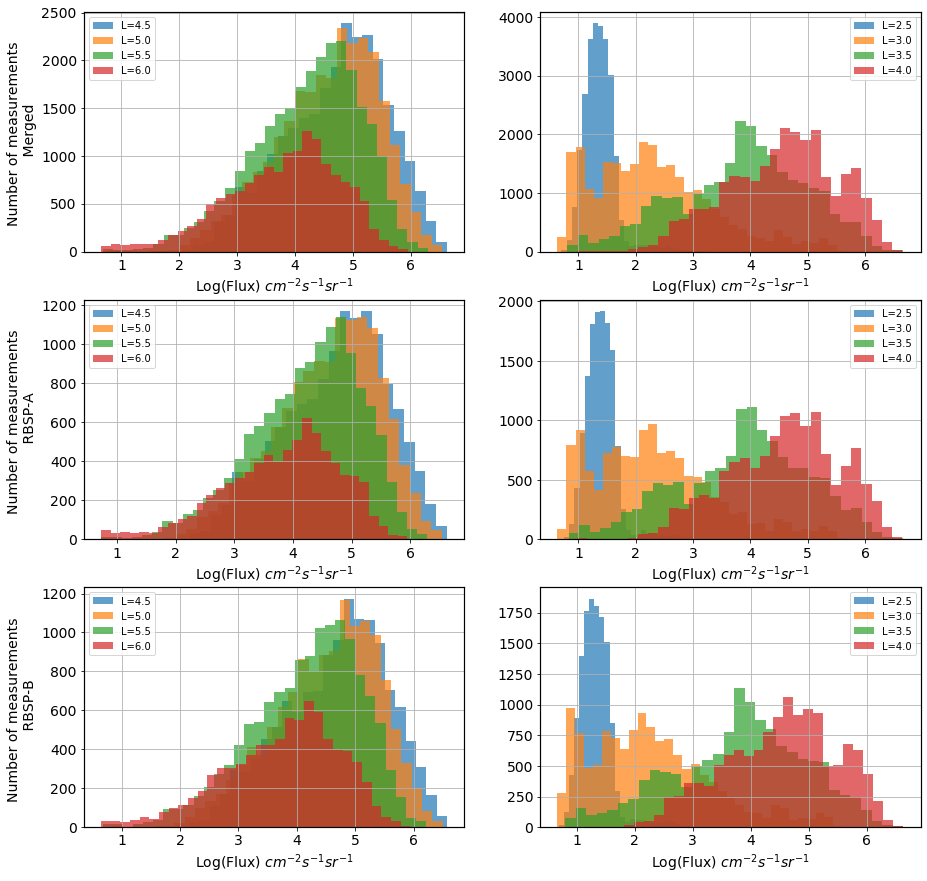

In [41]:

fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(321)
plotOptions()
plt.xlabel('Log(Flux) $cm^{-2}s^{-1}sr^{-1}$' , fontsize='14' )
plt.ylabel('Number of measurements \n Merged' , fontsize='14' )

rbData.E21log[rbData.L == 4.5].hist(alpha=0.7, bins=32, label='L=4.5', density=False)
rbData.E21log[rbData.L == 5.0].hist(alpha=0.7, bins=32, label='L=5.0', density=False)
rbData.E21log[rbData.L == 5.5].hist(alpha=0.7, bins=32, label='L=5.5', density=False)
rbData.E21log[rbData.L == 6.0].hist(alpha=0.7, bins=32, label='L=6.0', density=False)
#ax.set_yscale('log')
ax.legend(loc=2)

ax = fig.add_subplot(322)
plotOptions()
plt.xlabel('Log(Flux) $cm^{-2}s^{-1}sr^{-1}$' , fontsize='14' )
rbData.E21log[rbData.L == 2.5].hist(alpha=0.7, bins=32, label='L=2.5', density=False)
rbData.E21log[rbData.L == 3.0].hist(alpha=0.7, bins=32, label='L=3.0', density=False)
rbData.E21log[rbData.L == 3.5].hist(alpha=0.7, bins=32, label='L=3.5', density=False)
rbData.E21log[rbData.L == 4.0].hist(alpha=0.7, bins=32, label='L=4.0', density=False)
ax.legend()

ax = fig.add_subplot(323)
plotOptions()
plt.xlabel('Log(Flux) $cm^{-2}s^{-1}sr^{-1}$' , fontsize='14' )
plt.ylabel('Number of measurements \n RBSP-A' , fontsize='14' )

rbaData.E21log[rbaData.L == 4.5].hist(alpha=0.7, bins=32, label='L=4.5', density=False)
rbaData.E21log[rbaData.L == 5.0].hist(alpha=0.7, bins=32, label='L=5.0', density=False)
rbaData.E21log[rbaData.L == 5.5].hist(alpha=0.7, bins=32, label='L=5.5', density=False)
rbaData.E21log[rbaData.L == 6.0].hist(alpha=0.7, bins=32, label='L=6.0', density=False)
ax.legend(loc=2)

ax = fig.add_subplot(324)
plotOptions()
plt.xlabel('Log(Flux) $cm^{-2}s^{-1}sr^{-1}$' , fontsize='14' )
rbaData.E21log[rbaData.L == 2.5].hist(alpha=0.7, bins=32, label='L=2.5', density=False)
rbaData.E21log[rbaData.L == 3.0].hist(alpha=0.7, bins=32, label='L=3.0', density=False)
rbaData.E21log[rbaData.L == 3.5].hist(alpha=0.7, bins=32, label='L=3.5', density=False)
rbaData.E21log[rbaData.L == 4.0].hist(alpha=0.7, bins=32, label='L=4.0', density=False)
ax.legend()

ax = fig.add_subplot(325)
plotOptions()
plt.xlabel('Log(Flux) $cm^{-2}s^{-1}sr^{-1}$' , fontsize='14' )
plt.ylabel('Number of measurements \n RBSP-B' , fontsize='14' )

rbbData.E21log[rbbData.L == 4.5].hist(alpha=0.7, bins=32, label='L=4.5', density=False)
rbbData.E21log[rbbData.L == 5.0].hist(alpha=0.7, bins=32, label='L=5.0', density=False)
rbbData.E21log[rbbData.L == 5.5].hist(alpha=0.7, bins=32, label='L=5.5', density=False)
rbbData.E21log[rbbData.L == 6.0].hist(alpha=0.7, bins=32, label='L=6.0', density=False)
ax.legend(loc=2)

ax = fig.add_subplot(326)
plotOptions()
plt.xlabel('Log(Flux) $cm^{-2}s^{-1}sr^{-1}$' , fontsize='14' )
rbbData.E21log[rbbData.L == 2.5].hist(alpha=0.7, bins=32, label='L=2.5', density=False)
rbbData.E21log[rbbData.L == 3.0].hist(alpha=0.7, bins=32, label='L=3.0', density=False)
rbbData.E21log[rbbData.L == 3.5].hist(alpha=0.7, bins=32, label='L=3.5', density=False)
rbbData.E21log[rbbData.L == 4.0].hist(alpha=0.7, bins=32, label='L=4.0', density=False)
ax.legend()


plt.show()

## Flux distribution (every L)

It is actually tempting to look at every L-shell distribution of fluxes to try to identify this chances in the shape of the distribution, which can be indicative of a change in the dynamics of that part of the belt. From the plots, there seems to be a distinctive distribution in the region $2.5 < L < 2.8$, another distribution of similar shape, but in which the peak in flux increases significantly between $2.9 < L <  3.5$, a region in which the peak fluxes keep increasing but just marginally between $3.5 < L < 5.5$ and finally a region in which the distribution peak starts to decrease for $L > 5.5$

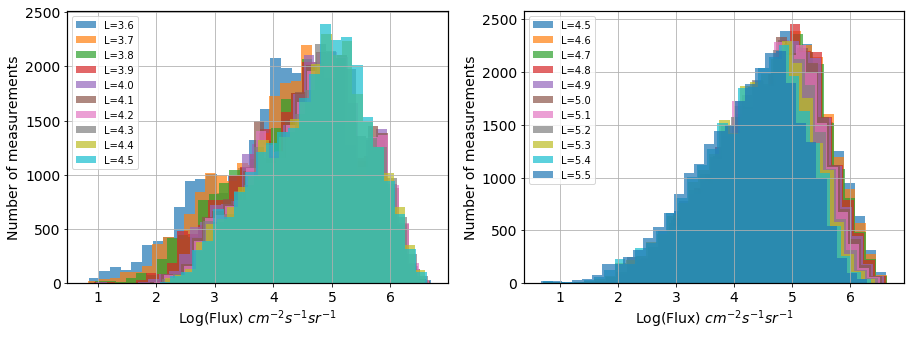

In [42]:
# fig = plt.figure(figsize=(15,5))
# ax1 = fig.add_subplot(121)
# plotOptions()
# plt.xlabel('Log(Flux) $cm^{-2}s^{-1}sr^{-1}$' , fontsize='14' )
# plt.ylabel('Number of measurements' , fontsize='14' )
# for j in range(5):
#     rbData.E21log[rbData.L == lArray[j]].hist(alpha=0.7, bins=32, label='L='+str(lArray[j]))
# ax1.legend(loc=2)

# ax2 = fig.add_subplot(122)
# plotOptions()
# plt.xlabel('Log(Flux) $cm^{-2}s^{-1}sr^{-1}$' , fontsize='14' )
# plt.ylabel('Number of measurements' , fontsize='14' )
# for j in range(8):
#     rbData.E21log[rbData.L == lArray[4+j]].hist(alpha=0.7, bins=32, label='L='+str(lArray[4+j]))
# ax2.legend()

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
plotOptions()
plt.xlabel('Log(Flux) $cm^{-2}s^{-1}sr^{-1}$' , fontsize='14' )
plt.ylabel('Number of measurements' , fontsize='14' )
for j in range(10):
    rbData.E21log[rbData.L == lArray[11+j]].hist(alpha=0.7, bins=32, label='L='+str(lArray[11+j]))
ax.legend(loc=2)

ax = fig.add_subplot(122)
plotOptions()
plt.xlabel('Log(Flux) $cm^{-2}s^{-1}sr^{-1}$' , fontsize='14' )
plt.ylabel('Number of measurements' , fontsize='14' )
for j in range(11):
    rbData.E21log[rbData.L == lArray[20+j]].hist(alpha=0.7, bins=32, label='L='+str(lArray[20+j]))
ax.legend()
plt.show()

# fig = plt.figure(figsize=(15,5))
# ax1 = fig.add_subplot(121)
# plotOptions()
# plt.xlabel('Log(Flux) $cm^{-2}s^{-1}sr^{-1}$' , fontsize='14' )
# plt.ylabel('Number of measurements' , fontsize='14' )
# for j in range(6):
#     rbData.E21log[rbData.L == lArray[30+j]].hist(alpha=0.7, bins=32, label='L='+str(lArray[30+j]))
# ax1.legend(loc=2)


## Cumulative Distributions (to do)

Want to check if the distribution of occurrence-fluxes follows a power law, or something interesting

In [43]:
#fit = powerlaw.Fit(np.array(rbbData.E34[rbbData.L == 5.0]), xmin=0.01, discrete=True)
#fit.power_law.plot_pdf( color= 'b',linestyle='--',label='fit ccdf')
#fit.plot_pdf( color= 'b')
#print('alpha= ',fit.power_law.alpha,'  sigma= ',fit.power_law.sigma)


# Flux distributions

## Simple L-dependent Description of Fluxes

We want to obtain the statistics for fluxes at a particular L-shell (average, median, quartiles, min/max). We will start also looking at the MLT distribution as we know that the distribution of measurement is not homogeneous. Table presents the values of mean, standard deviation, min/max and quartile distribution for every $L$-shell, independent of MLT differences.

In [44]:
describeFlux = pd.DataFrame()
for l in lArray:
    describeFlux['L'+str(l)] = rbData.E21[rbData.L == l].describe(percentiles=[0.01,0.1,0.25,0.55,0.75,0.90,0.99])
describeFlux
#describeFlux.T 

,L2.5,L2.6,L2.7,L2.8,L2.9,L3.0,L3.1,L3.2,L3.3,L3.4,...,L5.7,L5.8,L5.9,L6.0,L6.1,L6.2,L6.3,L6.4,L6.5,L6.6
count,26734.000000,26734.000000,26729.000000,26728.000000,26728.000000,26723.000000,2.672500e+04,2.672500e+04,2.672100e+04,2.671900e+04,...,2.552300e+04,2.286700e+04,1.931400e+04,15679.000000,12063.000000,8453.000000,5300.000000,3156.000000,1867.000000,1066.000000
mean,33.227710,64.552787,256.791075,920.614939,2634.714925,6225.841721,1.266202e+04,2.270521e+04,3.667155e+04,5.492598e+04,...,5.068570e+04,4.328847e+04,3.768843e+04,32162.891807,27042.565889,23253.388868,19150.268912,13467.119912,9989.564058,9138.043390
std,71.914440,315.326858,1538.582076,5166.938386,13138.478974,28444.907055,5.644924e+04,9.721269e+04,1.432561e+05,1.885933e+05,...,9.934431e+04,8.595120e+04,7.526108e+04,65389.863315,57510.556279,51712.457181,43576.580398,30021.238042,21822.571632,18729.233448
min,5.048600,4.892200,3.992600,4.119700,4.108100,4.308800,3.988200e+00,4.054400e+00,4.144100e+00,5.211900e+00,...,5.282500e+00,4.599900e+00,4.629400e+00,4.427500,4.678400,4.823900,4.636700,3.717700,5.050700,5.077100
1%,7.876726,6.776765,6.366416,6.108421,6.099196,6.263180,6.630796e+00,7.030148e+00,7.722020e+00,9.080844e+00,...,2.932296e+01,2.120608e+01,1.543651e+01,10.834382,8.141582,6.985708,6.473454,6.200390,5.720424,5.781180
10%,11.614870,9.294430,8.480480,8.232470,8.661030,10.041840,1.373584e+01,2.371756e+01,4.446240e+01,8.634964e+01,...,5.396565e+02,4.601589e+02,3.868300e+02,296.394500,200.242060,128.335680,66.261650,30.479700,14.611420,9.869300
25%,15.529700,11.631800,10.394400,10.547950,14.278600,33.428150,8.506180e+01,1.906281e+02,4.093169e+02,7.575857e+02,...,2.565328e+03,2.165547e+03,1.833214e+03,1411.349200,1029.398250,708.174800,431.753625,240.129000,119.828600,73.379775
50%,22.403750,15.986350,14.070100,19.394650,49.578150,156.436100,4.269040e+02,1.114876e+03,2.524594e+03,4.874419e+03,...,1.468210e+04,1.235697e+04,1.048001e+04,8266.977100,6327.198600,4669.456000,3237.658850,1888.501200,1167.669300,1026.192500
55.0%,24.096535,17.145180,15.082900,23.393210,64.794335,202.481920,6.050645e+02,1.504487e+03,3.252795e+03,6.265514e+03,...,1.916783e+04,1.614088e+04,1.376613e+04,11083.108830,8457.973670,6242.390920,4292.497130,2682.819900,1766.482050,1517.336675
75%,32.550625,23.169875,23.232600,64.729250,240.222225,819.658450,2.364132e+03,6.443026e+03,1.422193e+04,2.606381e+04,...,5.196819e+04,4.338567e+04,3.679499e+04,30555.861150,24287.903900,19585.466900,14978.301100,9838.256700,7395.240850,7503.098150


Figure show that fluxes increase as a function for $L < 4.5$ where they peak and start to slowly decrease. 

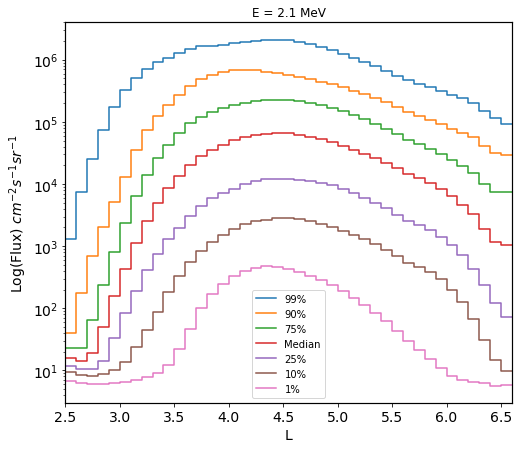

In [45]:
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
plotOptions()
plt.xlim(lArray[0],lArray[-1])
ax.set_yscale('log')
plt.ylabel('Log(Flux) $cm^{-2}s^{-1}sr^{-1}$' , fontsize='14' )
plt.xlabel('L' , fontsize='14' )
plt.title('E = 2.1 MeV')
#plt.step(lArray, describeFlux.loc['mean'], label = 'Mean')
plt.step(lArray, describeFlux.loc['99%'], label = '99%')
plt.step(lArray, describeFlux.loc['90%'], label = '90%')
plt.step(lArray, describeFlux.loc['75%'], label = '75%')
plt.step(lArray, describeFlux.loc['50%'], label = 'Median')
plt.step(lArray, describeFlux.loc['25%'], label = '25%')
plt.step(lArray, describeFlux.loc['10%'], label = '10%')
plt.step(lArray, describeFlux.loc['1%'], label = '1%')
plt.legend()
plt.show()

## MLT-L distribution of fluxes (median)

Figure also shows an assymetry in the fluxes as a function of MLT, which should be related (and we hope to find it later) to the occurrence of enhancement events. One of the criteria we can set to determine that we are actually removing all enhancements when we try to calculate the baseline can be that we actually get rid of the MLT asymmetry. 


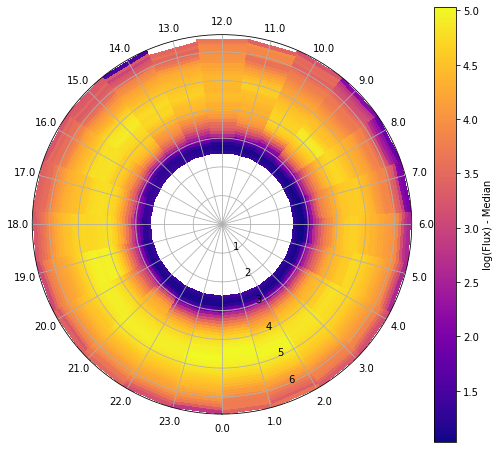

In [46]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='polar')
ax.set_theta_offset(np.pi*3/2)
plt.pcolormesh(th, r, binFluxMedian, cmap=cm2)
plt.plot(azm, r, ls='none')
plt.grid()
plt.thetagrids([theta * 15 for theta in range(360//15)], labels=mltArray)
plt.colorbar(aspect=20, fraction=0.1, label='log(Flux) - Median')
plt.show()

# ax3 = fig.add_subplot(133, projection='polar')
# ax3.set_theta_offset(np.pi*3/2)
# plt.pcolormesh(th, r, binFluxAvg, cmap=cm2)
# plt.plot(azm, r, ls='none')
# plt.grid()
# plt.thetagrids([theta * 15 for theta in range(360//15)], labels=mltArray)
# plt.colorbar(aspect=10, fraction=0.06, label='log(Flux) - Mean')
# plt.tight_layout()
# plt.show()

## Assymetry in MLT-Fluxes

There is no reason to have assymetry in MLT since we are dealing with ultrarelativistic energies. We can quantify the MLT assymetry (max flux/min flux) for every L and see if the value decreases when we try to remove the "enhancement events" from the sample. We will look at "Median Values" right now

In [47]:
MLTassymetry = np.zeros(len(lArray))

for l in range(len(lArray)):
    MLTassymetry[l] = np.nanmax(binFluxMedian[:,l])/np.nanmin(binFluxMedian[:,l])

In [48]:
np.nanmax(binFluxMedian, axis=0)

array([1.47900656, 1.36960633, 1.35230989, 1.7590889 , 2.06260492,
       2.57607274, 3.16219925, 3.63820279, 3.92761344, 4.15160691,
       4.26239891, 4.41493594, 4.59761894, 4.72530235, 4.84993584,
       4.91689104, 4.96282423, 4.96105901, 4.99228872, 5.01752388,
       5.00514285, 5.03079277, 5.01629445, 4.9859463 , 4.94021681,
       4.88508938, 4.8226984 , 4.75578352, 4.68682518, 4.60585685,
       4.53442567, 4.47814762, 4.4079866 , 4.33297802, 4.2408263 ,
       4.14698815, 4.02059254, 3.89419896, 3.93137436, 3.73143803,
       3.60881011, 3.83314049])

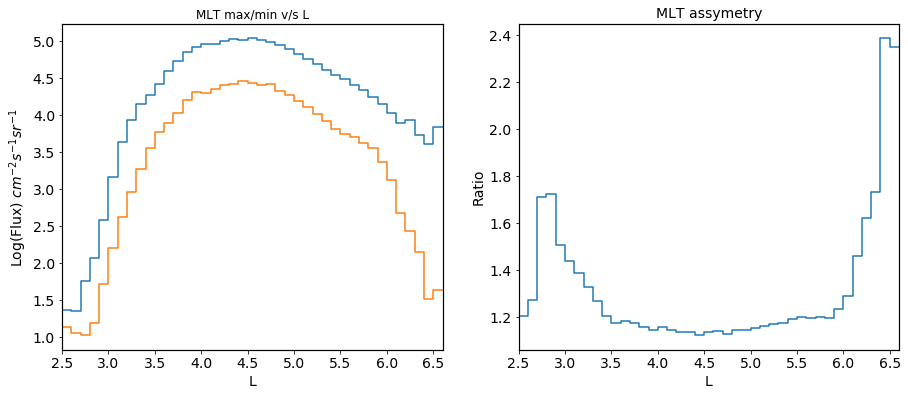

In [49]:
fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(121)
plotOptions()
plt.xlim(lArray[0],lArray[-1])

plt.ylabel('Log(Flux) $cm^{-2}s^{-1}sr^{-1}$' , fontsize='14' )
plt.xlabel('L' , fontsize='14' )
plt.title('MLT max/min v/s L')

plt.step(lArray, np.nanmax(binFluxMedian, axis=0))
plt.step(lArray, np.nanmin(binFluxMedian, axis=0))

ax = fig.add_subplot(122)
plotOptions()
plt.xlim(lArray[0],lArray[-1])

plt.ylabel('Ratio' , fontsize='14' )
plt.xlabel('L' , fontsize='14' )
plt.title('MLT assymetry', fontsize='14')
plt.step(lArray, MLTassymetry)

plt.show()


# GOES data

## Flux distribution (histogram)

We have gone through the process of loading 5 min resolution GOES data for the same period of time that for Van Allen Probes to compare one dataset against each other.

The most significant issue with directly comparing both datasets is that we are using GOES as a single measurement point (6.6 Re) but we have not calculated the L-value of those measurements. For a "truer" comparison, we should calculate L-values.

In [50]:
goesDir = '/Users/Victor/OneDrive/Research/current/rb-characterization/data/compressed-goes15/'
goes15files = glob.glob(goesDir+'goes15_*.dat')

g = []
goescols = ['Time', 'E06U', 'W06U', 'E20U', 'W20U', 'E40U']

for fil in goes15files:
    df = pd.read_csv(fil, delim_whitespace=True, header=None)
    g.append(df)  

goesData = pd.concat(g, axis = 0, ignore_index = True)
goesData.columns = goescols

goesData['W20Ulog'] = np.log10(goesData.W20U)
goesData['E20Ulog'] = np.log10(goesData.E20U)

Although relatively arbitrary, if we set up 1000 FU as the threshold for enhanced fluxes, then GOES 15 fluxes are above that value for a 31.1% of the time. 

In [51]:
describeGOES = goesData.W20U.describe(percentiles=[0.01,0.1,0.25,0.5,0.689,0.75,0.90,0.99])
describeGOES['68.9%']

1006.3025599999912

Distribution of fluxes show that there significantly more low fluxes (peak at 10^1 FU) and that there is a similar number of measurements for 10^2 up to 10^3 FU. Higher than 10^3 FU are less common and decrease as flux increases. Comparing to Van Allen Probes data at L=6.6, we can see that  low fluxes are also predominant (although data can be very biased). At slightly lower L-shells as the number of measurement increases, there is a quick change in shape that is relatively similar for all L > 3.0

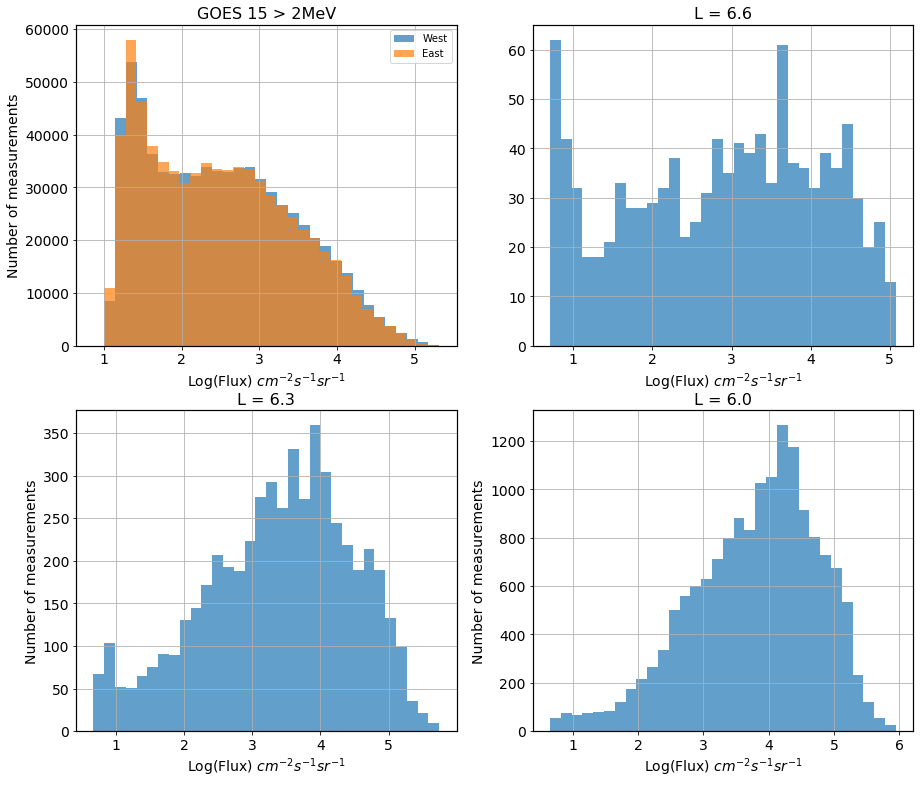

In [52]:
fig = plt.figure(figsize=(15,13))

ax = fig.add_subplot(221)
plotOptions()
plt.xlabel('Log(Flux) $cm^{-2}s^{-1}sr^{-1}$' , fontsize='14' )
plt.ylabel('Number of measurements' , fontsize='14' )
plt.title('GOES 15 > 2MeV', fontsize='16')
goesData.W20Ulog.hist(alpha=0.7, bins=32, density=False, label='West')
goesData.E20Ulog.hist(alpha=0.7, bins=32, density=False, label='East')
plt.legend()

ax = fig.add_subplot(222)
plotOptions()
plt.title('L = 6.6', fontsize='16')
plt.xlabel('Log(Flux) $cm^{-2}s^{-1}sr^{-1}$' , fontsize='14' )
rbData.E21log[rbData.L == 6.6].hist(alpha=0.7, bins=32, density=False)

ax = fig.add_subplot(223)
plotOptions()
plt.title('L = 6.3', fontsize='16')
plt.xlabel('Log(Flux) $cm^{-2}s^{-1}sr^{-1}$' , fontsize='14' )
plt.ylabel('Number of measurements' , fontsize='14' )
rbData.E21log[rbData.L == 6.3].hist(alpha=0.7, bins=32, density=False)

ax = fig.add_subplot(224)
plotOptions()
plt.title('L = 6.0', fontsize='16')
plt.xlabel('Log(Flux) $cm^{-2}s^{-1}sr^{-1}$' , fontsize='14' )
plt.ylabel('Number of measurements' , fontsize='14' )
rbData.E21log[rbData.L == 6.0].hist(alpha=0.7, bins=32, density=False)


plt.show()

## L-description of Fluxes including GOES

If we now compare the percentile distributions of Van Allen Probes with GOES, we can see that VAP overestimates in the higher percentiles and underestimate in the lower percentiles, with the 25% being the one that is "closer". There are several improvements that can be done here, such as calculating the flux statistics using the same time as the measurements at high L from Van Allen Probes

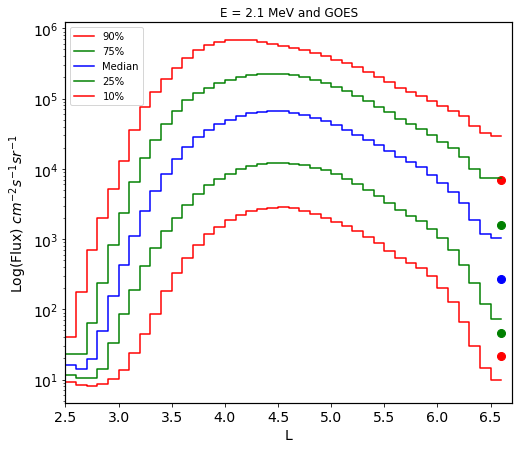

In [53]:
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
plotOptions()
plt.xlim(2.5,6.7)
ax.set_yscale('log')
plt.ylabel('Log(Flux) $cm^{-2}s^{-1}sr^{-1}$' , fontsize='14' )
plt.xlabel('L' , fontsize='14' )
plt.title('E = 2.1 MeV and GOES')

# plt.step(lArray, describeFlux.loc['min'], label = 'Min')
# plt.step(lArray, describeFlux.loc['99%'], label = '99%')
plt.step(lArray, describeFlux.loc['90%'], label = '90%', color='red')
plt.plot(6.6, describeGOES.loc['90%'], 'o', c='red', markersize=8)

plt.step(lArray, describeFlux.loc['75%'], label = '75%', color='green')
plt.plot(6.6, describeGOES.loc['75%'], 'o', c='green', markersize=8)

plt.step(lArray, describeFlux.loc['50%'], label = 'Median', c='blue')
plt.plot(6.6, describeGOES.loc['50%'], 'o', c='blue', markersize=8)

plt.step(lArray, describeFlux.loc['25%'], label = '25%', color='green')
plt.plot(6.6, describeGOES.loc['25%'], 'o', c='green', markersize=8)

plt.step(lArray, describeFlux.loc['10%'], label = '10%', color='red')
plt.plot(6.6, describeGOES.loc['10%'], 'o', c='red', markersize=8)
# plt.step(lArray, describeFlux.loc['1%'], label = '1%')
# plt.step(lArray, describeFlux.loc['max'], label = 'Max')

plt.legend()
plt.show()

# Removing Enhancement Events

## Loading the enhancement dataset (Now until July 2019)

Just for convenience we are using two different datasets (I'm also using them in a different study). Enhancement events that are also occurring at Geostationary orbit, as determined by the increase to more than $10^3$ FU in less than 48 hours following a dropout, and a dataset of events that considers enhancements measured in at least $\Delta L = 0.5$ across the radiation belt, but that for one reason or another are not considered enhancement events at geostationary orbit.

The dataset covers from September 2012 to July 2019.

In [73]:
import pandas as pd
import datetime as dt

dataDir = '/Users/Victor/OneDrive/Research/current/rb-characterization/'

enhGEO = pd.read_csv(dataDir+'enhancement_list.txt', header=None, names=['RawDate'])
enhNoGEO = pd.read_csv(dataDir+'enhancement_list_no_geo.txt', header=None, names=['RawDate'])

enhGEO['pdDate'] = pd.to_datetime(enhGEO.RawDate, format='%Y-%m-%d/%H:%M:%S')
enhNoGEO['pdDate'] = pd.to_datetime(enhNoGEO.RawDate, format='%Y-%m-%d/%H:%M:%S')

enhGEO.pdDate.sample(5)

30   2016-05-08 13:00:00
69   2019-02-01 12:00:00
14   2014-12-07 12:00:00
37   2016-10-13 19:00:00
60   2018-02-18 00:00:00
Name: pdDate, dtype: datetime64[ns]

##  Visualizing the entire dataset

Figure shows $E=2.1$ MeV electron data from REPT instrument for the whole period of 2012-2019 for different L-shells (one per panel) from 6.0 down to 2.5. We have overplotted the lists of enhancement events, GEO events (red) and non-GEO events (green). From this figure it is clear that not all enhancement events occur at all L-shells, but more importantly, that there is a significant variability between events at a same L-shell (several orders of magnitude).

This is a time series summary of the variability of the outer radiation belt in a period of almost 6 years.

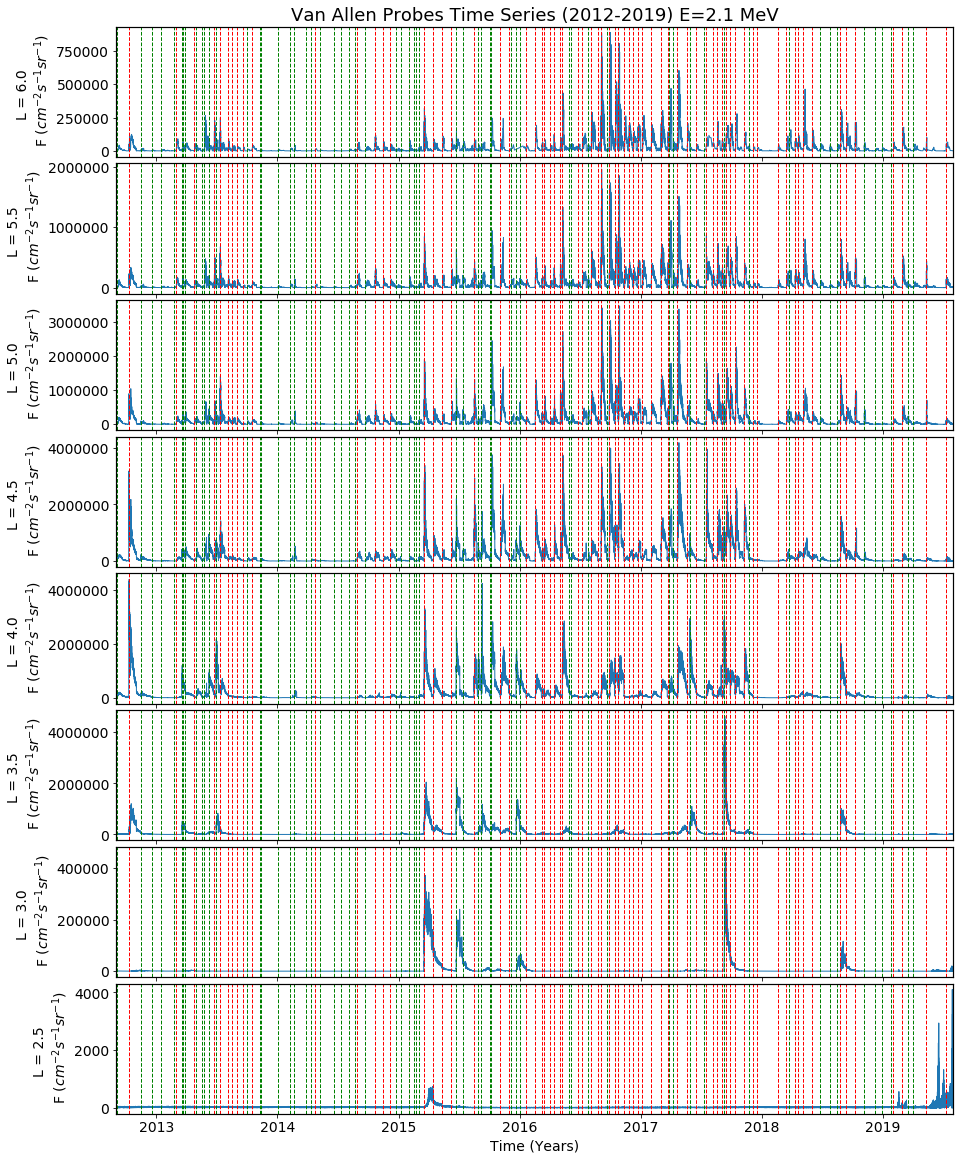

In [55]:
def thisPlotOptions(L):
    plt.ylabel('L = %s \n F ($cm^{-2}s^{-1}sr^{-1}$)' % L, fontsize=14)
    plt.xlabel('Time (Years)', fontsize=14)
    plt.xlim(rbData.pdDate.iloc[0],rbData.pdDate.iloc[-1])
    #ax.set_yscale('log')

fig = plt.figure(figsize=(15,20))
plt.subplots_adjust(hspace=0.05)

ax = fig.add_subplot(811)
L = 6.0
plotOptions()
thisPlotOptions(L)
plt.title('Van Allen Probes Time Series (2012-2019) E=2.1 MeV', fontsize=18)
plt.tick_params(axis='x', labelbottom='off')
plt.plot(rbData.pdDate[rbData.L == L],rbData.E21[rbData.L == L],linewidth=1)
axvlines(enhGEO.pdDate, color='red', linestyle='--', linewidth=1)
axvlines(enhNoGEO.pdDate, color='green', linestyle='--', linewidth=1)

ax = fig.add_subplot(812)
L = 5.5
plotOptions()
thisPlotOptions(L)
plt.tick_params(axis='x', labelbottom='off')
plt.plot(rbData.pdDate[rbData.L == L],rbData.E21[rbData.L == L],linewidth=1)
axvlines(enhGEO.pdDate, color='red', linestyle='--', linewidth=1)
axvlines(enhNoGEO.pdDate, color='green', linestyle='--', linewidth=1)

ax = fig.add_subplot(813)
L = 5.0
plotOptions()
thisPlotOptions(L)
plt.tick_params(axis='x', labelbottom='off')
plt.plot(rbData.pdDate[rbData.L == L],rbData.E21[rbData.L == L],linewidth=1)
axvlines(enhGEO.pdDate, color='red', linestyle='--', linewidth=1)
axvlines(enhNoGEO.pdDate, color='green', linestyle='--', linewidth=1)

ax = fig.add_subplot(814)
L = 4.5
plotOptions()
thisPlotOptions(L)
plt.tick_params(axis='x', labelbottom='off')
plt.plot(rbData.pdDate[rbData.L == L],rbData.E21[rbData.L == L],linewidth=1)
axvlines(enhGEO.pdDate, color='red', linestyle='--', linewidth=1)
axvlines(enhNoGEO.pdDate, color='green', linestyle='--', linewidth=1)

ax = fig.add_subplot(815)
L = 4.0
plotOptions()
thisPlotOptions(L)
plt.tick_params(axis='x', labelbottom='off')
plt.plot(rbData.pdDate[rbData.L == L],rbData.E21[rbData.L == L],linewidth=1)
axvlines(enhGEO.pdDate, color='red', linestyle='--', linewidth=1)
axvlines(enhNoGEO.pdDate, color='green', linestyle='--', linewidth=1)

ax = fig.add_subplot(816)
L = 3.5
plotOptions()
thisPlotOptions(L)
plt.tick_params(axis='x', labelbottom='off')
plt.plot(rbData.pdDate[rbData.L == L],rbData.E21[rbData.L == L],linewidth=1)
axvlines(enhGEO.pdDate, color='red', linestyle='--', linewidth=1)
axvlines(enhNoGEO.pdDate, color='green', linestyle='--', linewidth=1)

ax = fig.add_subplot(817)
L = 3.0
plotOptions()
thisPlotOptions(L)
plt.tick_params(axis='x', labelbottom='off')
plt.plot(rbData.pdDate[rbData.L == L],rbData.E21[rbData.L == L],linewidth=1)
axvlines(enhGEO.pdDate, color='red', linestyle='--', linewidth=1)
axvlines(enhNoGEO.pdDate, color='green', linestyle='--', linewidth=1)

ax = fig.add_subplot(818)
L = 2.5
plotOptions()
thisPlotOptions(L)
plt.tick_params(axis='x', labelbottom='off')
plt.plot(rbData.pdDate[rbData.L == L],rbData.E21[rbData.L == L],linewidth=1)
axvlines(enhGEO.pdDate, color='red', linestyle='--', linewidth=1)
axvlines(enhNoGEO.pdDate, color='green', linestyle='--', linewidth=1)

plt.show()


Same as previous figure but with y-axis in log scale. Although very cluttered, figure shows that there are indeed a significant number of enhancement events that don't show up clearly in linear scales, based on the flux variability from event to event. 

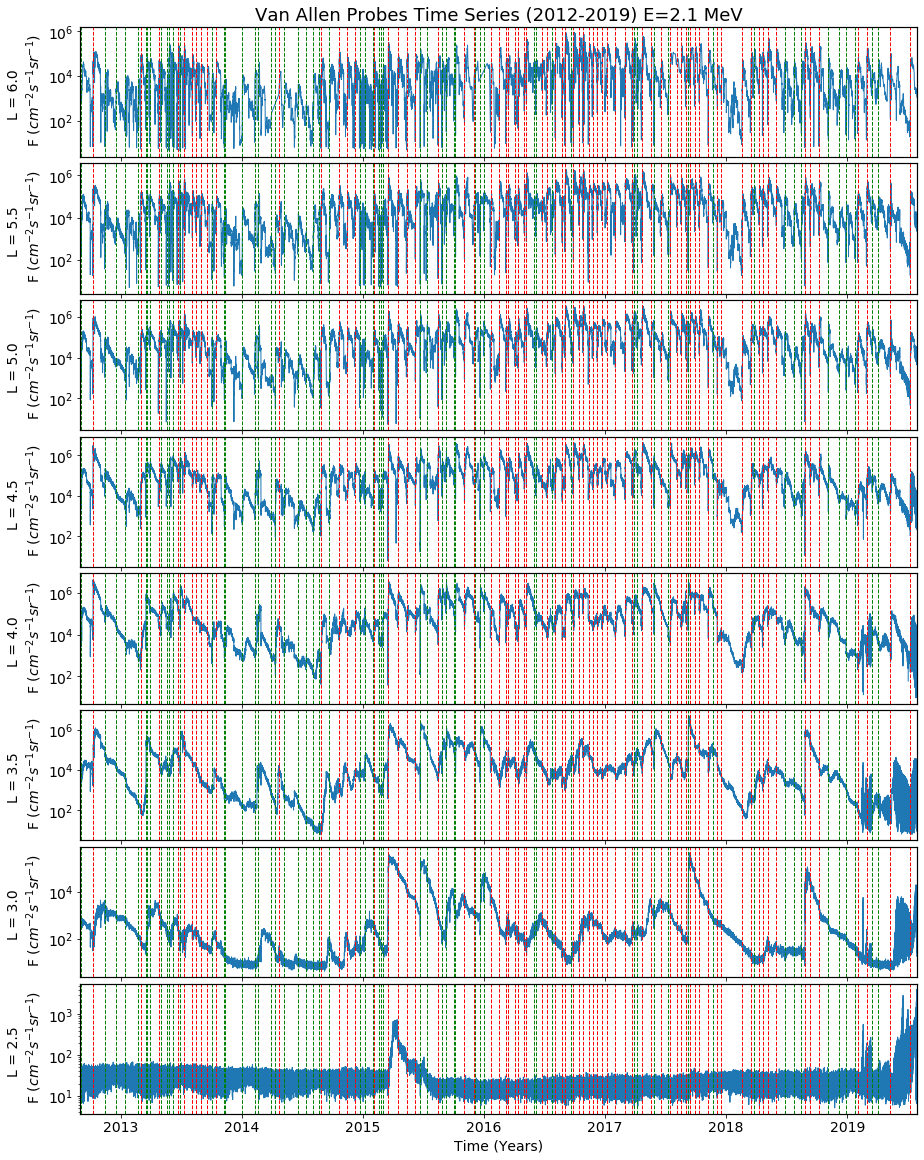

In [56]:
def thisPlotOptions(L):
    plt.ylabel('L = %s \n F ($cm^{-2}s^{-1}sr^{-1}$)' % L, fontsize=14)
    plt.xlabel('Time (Years)', fontsize=14)
    plt.xlim(rbData.pdDate.iloc[0],rbData.pdDate.iloc[-1])
    ax.set_yscale('log')

fig = plt.figure(figsize=(15,20))
plt.subplots_adjust(hspace=0.05)

ax = fig.add_subplot(811)
L = 6.0
plotOptions()
thisPlotOptions(L)
plt.title('Van Allen Probes Time Series (2012-2019) E=2.1 MeV', fontsize=18)
plt.tick_params(axis='x', labelbottom='off')
plt.plot(rbData.pdDate[rbData.L == L],rbData.E21[rbData.L == L],linewidth=1)
axvlines(enhGEO.pdDate, color='red', linestyle='--', linewidth=1)
axvlines(enhNoGEO.pdDate, color='green', linestyle='--', linewidth=1)

ax = fig.add_subplot(812)
L = 5.5
plotOptions()
thisPlotOptions(L)
plt.tick_params(axis='x', labelbottom='off')
plt.plot(rbData.pdDate[rbData.L == L],rbData.E21[rbData.L == L],linewidth=1)
axvlines(enhGEO.pdDate, color='red', linestyle='--', linewidth=1)
axvlines(enhNoGEO.pdDate, color='green', linestyle='--', linewidth=1)

ax = fig.add_subplot(813)
L = 5.0
plotOptions()
thisPlotOptions(L)
plt.tick_params(axis='x', labelbottom='off')
plt.plot(rbData.pdDate[rbData.L == L],rbData.E21[rbData.L == L],linewidth=1)
axvlines(enhGEO.pdDate, color='red', linestyle='--', linewidth=1)
axvlines(enhNoGEO.pdDate, color='green', linestyle='--', linewidth=1)

ax = fig.add_subplot(814)
L = 4.5
plotOptions()
thisPlotOptions(L)
plt.tick_params(axis='x', labelbottom='off')
plt.plot(rbData.pdDate[rbData.L == L],rbData.E21[rbData.L == L],linewidth=1)
axvlines(enhGEO.pdDate, color='red', linestyle='--', linewidth=1)
axvlines(enhNoGEO.pdDate, color='green', linestyle='--', linewidth=1)

ax = fig.add_subplot(815)
L = 4.0
plotOptions()
thisPlotOptions(L)
plt.tick_params(axis='x', labelbottom='off')
plt.plot(rbData.pdDate[rbData.L == L],rbData.E21[rbData.L == L],linewidth=1)
axvlines(enhGEO.pdDate, color='red', linestyle='--', linewidth=1)
axvlines(enhNoGEO.pdDate, color='green', linestyle='--', linewidth=1)

ax = fig.add_subplot(816)
L = 3.5
plotOptions()
thisPlotOptions(L)
plt.tick_params(axis='x', labelbottom='off')
plt.plot(rbData.pdDate[rbData.L == L],rbData.E21[rbData.L == L],linewidth=1)
axvlines(enhGEO.pdDate, color='red', linestyle='--', linewidth=1)
axvlines(enhNoGEO.pdDate, color='green', linestyle='--', linewidth=1)

ax = fig.add_subplot(817)
L = 3.0
plotOptions()
thisPlotOptions(L)
plt.tick_params(axis='x', labelbottom='off')
plt.plot(rbData.pdDate[rbData.L == L],rbData.E21[rbData.L == L],linewidth=1)
axvlines(enhGEO.pdDate, color='red', linestyle='--', linewidth=1)
axvlines(enhNoGEO.pdDate, color='green', linestyle='--', linewidth=1)

ax = fig.add_subplot(818)
L = 2.5
plotOptions()
thisPlotOptions(L)
plt.tick_params(axis='x', labelbottom='off')
plt.plot(rbData.pdDate[rbData.L == L],rbData.E21[rbData.L == L],linewidth=1)
axvlines(enhGEO.pdDate, color='red', linestyle='--', linewidth=1)
axvlines(enhNoGEO.pdDate, color='green', linestyle='--', linewidth=1)

plt.show()


## Visualizing the dataset in a yearly basis

Although plotting the whole Van Allen Probes mission give us some nice information, it is difficult to check of the accuracy of the enhancements. Figure shows the same type of plot as previously presented, but in a yearly basis, so it is possible to identify every enhancement event and the corresponding fluxes across different L-shells. Notice how below $L=3.5$ the enhancements tend to last longer, be less common and slowly decay.

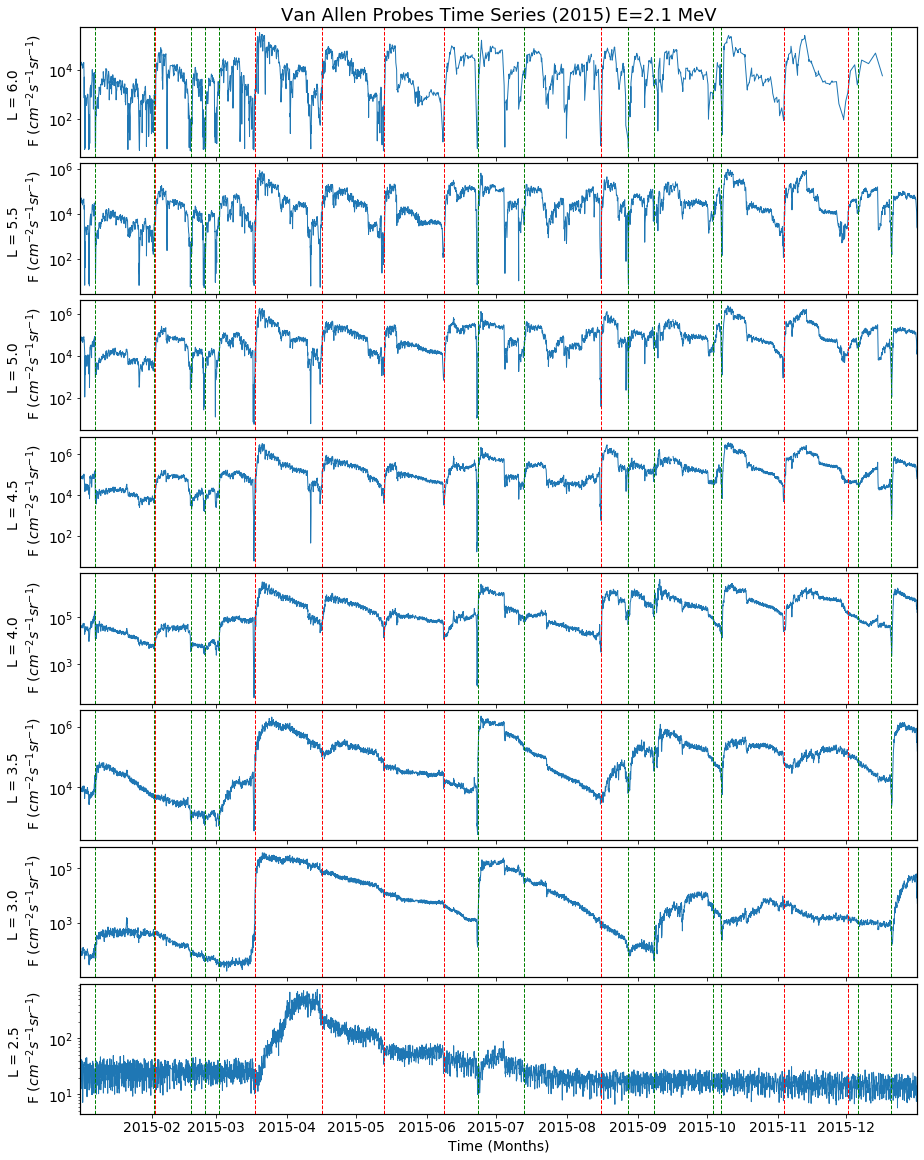

In [57]:
def thisPlotOptions(L, year):
    plt.ylabel('L = %s \n F ($cm^{-2}s^{-1}sr^{-1}$)' % L, fontsize=14)
    plt.xlabel('Time (Months)', fontsize=14)
    plt.xlim(rbData[year].pdDate.iloc[0],rbData[year].pdDate.iloc[-1])
    ax.set_yscale('log')

fig = plt.figure(figsize=(15,20))
plt.subplots_adjust(hspace=0.05)
year = '2015'

ax = fig.add_subplot(811)
L = 6.0
plotOptions()
thisPlotOptions(L, year)
plt.title('Van Allen Probes Time Series (%s) E=2.1 MeV' %year, fontsize=18)
plt.tick_params(axis='x', labelbottom='off')
plt.plot(rbData[year].pdDate[rbData.L == L],rbData[year].E21[rbData.L == L],linewidth=1)
axvlines(enhGEO.pdDate, color='red', linestyle='--', linewidth=1)
axvlines(enhNoGEO.pdDate, color='green', linestyle='--', linewidth=1)

ax = fig.add_subplot(812)
L = 5.5
plotOptions()
thisPlotOptions(L, year)
plt.tick_params(axis='x', labelbottom='off')
plt.plot(rbData[year].pdDate[rbData.L == L],rbData[year].E21[rbData.L == L],linewidth=1)
axvlines(enhGEO.pdDate, color='red', linestyle='--', linewidth=1)
axvlines(enhNoGEO.pdDate, color='green', linestyle='--', linewidth=1)

ax = fig.add_subplot(813)
L = 5.0
plotOptions()
thisPlotOptions(L, year)
plt.tick_params(axis='x', labelbottom='off')
plt.plot(rbData[year].pdDate[rbData.L == L],rbData[year].E21[rbData.L == L],linewidth=1)
axvlines(enhGEO.pdDate, color='red', linestyle='--', linewidth=1)
axvlines(enhNoGEO.pdDate, color='green', linestyle='--', linewidth=1)

ax = fig.add_subplot(814)
L = 4.5
plotOptions()
thisPlotOptions(L, year)
plt.tick_params(axis='x', labelbottom='off')
plt.plot(rbData[year].pdDate[rbData.L == L],rbData[year].E21[rbData.L == L],linewidth=1)
axvlines(enhGEO.pdDate, color='red', linestyle='--', linewidth=1)
axvlines(enhNoGEO.pdDate, color='green', linestyle='--', linewidth=1)

ax = fig.add_subplot(815)
L = 4.0
plotOptions()
thisPlotOptions(L, year)
plt.tick_params(axis='x', labelbottom='off')
plt.plot(rbData[year].pdDate[rbData.L == L],rbData[year].E21[rbData.L == L],linewidth=1)
axvlines(enhGEO.pdDate, color='red', linestyle='--', linewidth=1)
axvlines(enhNoGEO.pdDate, color='green', linestyle='--', linewidth=1)

ax = fig.add_subplot(816)
L = 3.5
plotOptions()
thisPlotOptions(L, year)
plt.tick_params(axis='x', labelbottom='off')
plt.plot(rbData[year].pdDate[rbData.L == L],rbData[year].E21[rbData.L == L],linewidth=1)
axvlines(enhGEO.pdDate, color='red', linestyle='--', linewidth=1)
axvlines(enhNoGEO.pdDate, color='green', linestyle='--', linewidth=1)

ax = fig.add_subplot(817)
L = 3.0
plotOptions()
thisPlotOptions(L, year)
plt.tick_params(axis='x', labelbottom='off')
plt.plot(rbData[year].pdDate[rbData.L == L],rbData[year].E21[rbData.L == L],linewidth=1)
axvlines(enhGEO.pdDate, color='red', linestyle='--', linewidth=1)
axvlines(enhNoGEO.pdDate, color='green', linestyle='--', linewidth=1)

ax = fig.add_subplot(818)
L = 2.5
plotOptions()
thisPlotOptions(L, year)
plt.tick_params(axis='x', labelbottom='off')
plt.plot(rbData[year].pdDate[rbData.L == L],rbData[year].E21[rbData.L == L],linewidth=1)
axvlines(enhGEO.pdDate, color='red', linestyle='--', linewidth=1)
axvlines(enhNoGEO.pdDate, color='green', linestyle='--', linewidth=1)

plt.show()


## Defining a length for the events

For the purpose of the study, we want to determine a "length" of each enhancement event. By doing that we can remove the data between start and end of each enhancement from the dataset and recalculate the statistics of occurrence. Ideally, this should help improve the characteristic values of the belt. It is clear that each enhancement has its own duration, for each event, each L-shell and possibly each energy channel. However in a first approximation we will start by defining events with a duration ofone week and up to two weeks period.

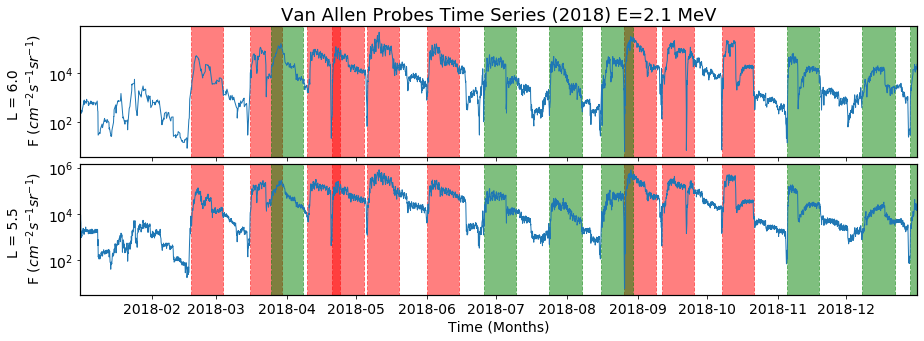

In [58]:
useDays = 14
year = '2018'

def thisPlotOptions(L, year):
    plt.ylabel('L = %s \n F ($cm^{-2}s^{-1}sr^{-1}$)' % L, fontsize=14)
    plt.xlabel('Time (Months)', fontsize=14)
    plt.xlim(rbData[year].pdDate.iloc[0],rbData[year].pdDate.iloc[-1])
    ax.set_yscale('log')

fig = plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.05)

ax = fig.add_subplot(411)
L = 6.0
plotOptions()
thisPlotOptions(L, year)
plt.title('Van Allen Probes Time Series (%s) E=2.1 MeV' %year, fontsize=18)
plt.tick_params(axis='x', labelbottom='off')
plt.plot(rbData[year].pdDate[rbData.L == L],rbData[year].E21[rbData.L == L],linewidth=1)
for date in enhGEO.pdDate:
    plt.axvspan(date, date+pd.Timedelta('%s day' % useDays), color='red', linestyle='--', linewidth=1, alpha=0.5)
for date in enhNoGEO.pdDate:
    plt.axvspan(date, date+pd.Timedelta('%s day' % useDays), color='green', linestyle='--', linewidth=1, alpha=0.5)

ax = fig.add_subplot(412)
L = 5.5
plotOptions()
thisPlotOptions(L, year)
plt.tick_params(axis='x', labelbottom='off')
plt.plot(rbData[year].pdDate[rbData.L == L],rbData[year].E21[rbData.L == L],linewidth=1)
for date in enhGEO.pdDate:
    plt.axvspan(date, date+pd.Timedelta('%s day' % useDays), color='red', linestyle='--', linewidth=1, alpha=0.5)
for date in enhNoGEO.pdDate:
    plt.axvspan(date, date+pd.Timedelta('%s day' % useDays), color='green', linestyle='--', linewidth=1, alpha=0.5)

plt.show()

## How does removing enhancement events affects the distribution?

We have removed the data associated with each event, however, it is clear that by doing so, we have removed a significant portion of the measurements (around 2/3 of the dataset) yet, there is still plenty of "high fluxes". It is clear that at least at high $L$-shells the radiation belt is in a state of significant enhancment constantly.

In [74]:
allEnhancementEvents = pd.concat([enhGEO.pdDate, enhNoGEO.pdDate]).sort_values().reset_index()

start = rbData.index[0]
rbNoEnhancement = pd.DataFrame()

for d in range(len(allEnhancementEvents.pdDate)-1):
    start_remove = allEnhancementEvents.pdDate[d]
    end_remove = allEnhancementEvents.pdDate[d] + pd.Timedelta('%s day' % useDays)
    end = allEnhancementEvents.pdDate[d+1]
    
    rbNoEnhancement = pd.concat([rbNoEnhancement, rbData[start:start_remove], rbData[end_remove:end]])
    start = allEnhancementEvents.pdDate[d+1]

rbNoEnhancement.describe()

,epoch,L,MLT,E18,E21,E26,E34,E42,E52,E63,E72,E21log
count,3.353840e+05,335384.000000,335384.000000,3.351480e+05,3.351480e+05,335148.000000,335148.000000,335148.000000,335148.000000,335147.000000,335147.000000,335148.000000
mean,6.362207e+13,4.267075,11.968231,8.253235e+04,3.867083e+04,14926.380905,4196.485431,870.255371,219.247195,33.983687,4.924284,3.412150
std,6.864624e+10,1.058162,6.875386,2.100035e+05,1.074162e+05,48027.874409,15982.247341,3817.207360,1120.043552,171.920134,9.911970,1.266333
min,6.351372e+13,2.500000,0.000000,8.650100e+00,3.717700e+00,1.873900,1.539800,0.000000,1.392900,1.210000,1.136500,0.570274
25%,6.356154e+13,3.400000,5.840000,9.531088e+02,3.906259e+02,100.751200,15.015375,3.714875,3.643400,3.520200,2.889600,2.591761
50%,6.361336e+13,4.300000,11.950000,9.883409e+03,3.589226e+03,860.034950,128.793050,17.006500,5.767300,4.708600,3.397100,3.555001
75%,6.368752e+13,5.200000,17.800000,5.923318e+04,2.340956e+04,6624.036950,1258.289200,182.925350,36.579625,7.717700,4.087100,4.369393
max,6.372994e+13,6.600000,23.990000,3.639125e+06,1.909754e+06,958889.040500,373990.904500,105697.660300,40926.609300,5977.449400,856.088700,6.280977


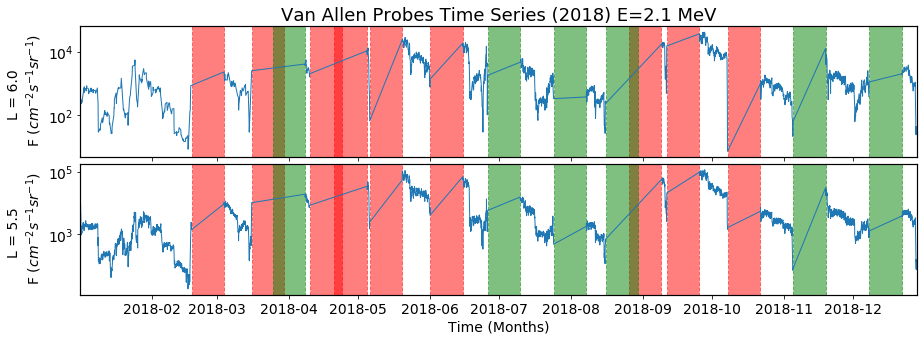

In [60]:
year = '2018'

def thisPlotOptions(L, year):
    plt.ylabel('L = %s \n F ($cm^{-2}s^{-1}sr^{-1}$)' % L, fontsize=14)
    plt.xlabel('Time (Months)', fontsize=14)
    plt.xlim(rbNoEnhancement[year].pdDate.iloc[0],rbNoEnhancement[year].pdDate.iloc[-1])
    ax.set_yscale('log')

fig = plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.05)

ax = fig.add_subplot(411)
L = 6.0
plotOptions()
thisPlotOptions(L, year)
plt.title('Van Allen Probes Time Series (%s) E=2.1 MeV' %year, fontsize=18)
plt.tick_params(axis='x', labelbottom='off')
plt.plot(rbNoEnhancement[year].pdDate[rbNoEnhancement.L == L],rbNoEnhancement[year].E21[rbNoEnhancement.L == L],linewidth=1)
for date in enhGEO.pdDate:
    plt.axvspan(date, date+pd.Timedelta('%s day' % useDays), color='red', linestyle='--', linewidth=1, alpha=0.5)
for date in enhNoGEO.pdDate:
    plt.axvspan(date, date+pd.Timedelta('%s day' % useDays), color='green', linestyle='--', linewidth=1, alpha=0.5)

ax = fig.add_subplot(412)
L = 5.5
plotOptions()
thisPlotOptions(L, year)
plt.tick_params(axis='x', labelbottom='off')
plt.plot(rbNoEnhancement[year].pdDate[rbNoEnhancement.L == L],rbNoEnhancement[year].E21[rbNoEnhancement.L == L],linewidth=1)
for date in enhGEO.pdDate:
    plt.axvspan(date, date+pd.Timedelta('%s day' % useDays), color='red', linestyle='--', linewidth=1, alpha=0.5)
for date in enhNoGEO.pdDate:
    plt.axvspan(date, date+pd.Timedelta('%s day' % useDays), color='green', linestyle='--', linewidth=1, alpha=0.5)

plt.show()

In [61]:
describeNoEnhancement = pd.DataFrame()
for l in lArray:
    describeNoEnhancement['L'+str(l)] = rbNoEnhancement.E21[rbData.L == l].describe(percentiles=[0.01,0.1,0.25,0.55,0.75,0.90,0.99])
describeFlux
#describeFlux.T 

,L2.5,L2.6,L2.7,L2.8,L2.9,L3.0,L3.1,L3.2,L3.3,L3.4,...,L5.7,L5.8,L5.9,L6.0,L6.1,L6.2,L6.3,L6.4,L6.5,L6.6
count,26734.000000,26734.000000,26729.000000,26728.000000,26728.000000,26723.000000,2.672500e+04,2.672500e+04,2.672100e+04,2.671900e+04,...,2.552300e+04,2.286700e+04,1.931400e+04,15679.000000,12063.000000,8453.000000,5300.000000,3156.000000,1867.000000,1066.000000
mean,33.227710,64.552787,256.791075,920.614939,2634.714925,6225.841721,1.266202e+04,2.270521e+04,3.667155e+04,5.492598e+04,...,5.068570e+04,4.328847e+04,3.768843e+04,32162.891807,27042.565889,23253.388868,19150.268912,13467.119912,9989.564058,9138.043390
std,71.914440,315.326858,1538.582076,5166.938386,13138.478974,28444.907055,5.644924e+04,9.721269e+04,1.432561e+05,1.885933e+05,...,9.934431e+04,8.595120e+04,7.526108e+04,65389.863315,57510.556279,51712.457181,43576.580398,30021.238042,21822.571632,18729.233448
min,5.048600,4.892200,3.992600,4.119700,4.108100,4.308800,3.988200e+00,4.054400e+00,4.144100e+00,5.211900e+00,...,5.282500e+00,4.599900e+00,4.629400e+00,4.427500,4.678400,4.823900,4.636700,3.717700,5.050700,5.077100
1%,7.876726,6.776765,6.366416,6.108421,6.099196,6.263180,6.630796e+00,7.030148e+00,7.722020e+00,9.080844e+00,...,2.932296e+01,2.120608e+01,1.543651e+01,10.834382,8.141582,6.985708,6.473454,6.200390,5.720424,5.781180
10%,11.614870,9.294430,8.480480,8.232470,8.661030,10.041840,1.373584e+01,2.371756e+01,4.446240e+01,8.634964e+01,...,5.396565e+02,4.601589e+02,3.868300e+02,296.394500,200.242060,128.335680,66.261650,30.479700,14.611420,9.869300
25%,15.529700,11.631800,10.394400,10.547950,14.278600,33.428150,8.506180e+01,1.906281e+02,4.093169e+02,7.575857e+02,...,2.565328e+03,2.165547e+03,1.833214e+03,1411.349200,1029.398250,708.174800,431.753625,240.129000,119.828600,73.379775
50%,22.403750,15.986350,14.070100,19.394650,49.578150,156.436100,4.269040e+02,1.114876e+03,2.524594e+03,4.874419e+03,...,1.468210e+04,1.235697e+04,1.048001e+04,8266.977100,6327.198600,4669.456000,3237.658850,1888.501200,1167.669300,1026.192500
55.0%,24.096535,17.145180,15.082900,23.393210,64.794335,202.481920,6.050645e+02,1.504487e+03,3.252795e+03,6.265514e+03,...,1.916783e+04,1.614088e+04,1.376613e+04,11083.108830,8457.973670,6242.390920,4292.497130,2682.819900,1766.482050,1517.336675
75%,32.550625,23.169875,23.232600,64.729250,240.222225,819.658450,2.364132e+03,6.443026e+03,1.422193e+04,2.606381e+04,...,5.196819e+04,4.338567e+04,3.679499e+04,30555.861150,24287.903900,19585.466900,14978.301100,9838.256700,7395.240850,7503.098150


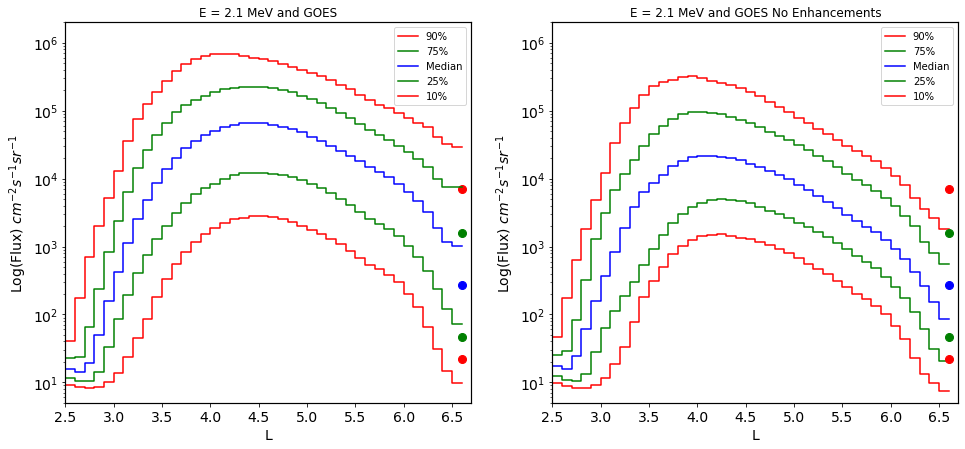

In [62]:
fig = plt.figure(figsize=(16,7))

ax = fig.add_subplot(121)
plotOptions()
plt.xlim(2.5,6.7)
plt.ylim(5e0,2e6)
ax.set_yscale('log')
plt.ylabel('Log(Flux) $cm^{-2}s^{-1}sr^{-1}$' , fontsize='14' )
plt.xlabel('L' , fontsize='14' )
plt.title('E = 2.1 MeV and GOES')

# plt.step(lArray, describeFlux.loc['min'], label = 'Min')
# plt.step(lArray, describeFlux.loc['99%'], label = '99%')
plt.step(lArray, describeFlux.loc['90%'], label = '90%', color='red')
plt.plot(6.6, describeGOES.loc['90%'], 'o', c='red', markersize=8)

plt.step(lArray, describeFlux.loc['75%'], label = '75%', color='green')
plt.plot(6.6, describeGOES.loc['75%'], 'o', c='green', markersize=8)

plt.step(lArray, describeFlux.loc['50%'], label = 'Median', c='blue')
plt.plot(6.6, describeGOES.loc['50%'], 'o', c='blue', markersize=8)

plt.step(lArray, describeFlux.loc['25%'], label = '25%', color='green')
plt.plot(6.6, describeGOES.loc['25%'], 'o', c='green', markersize=8)

plt.step(lArray, describeFlux.loc['10%'], label = '10%', color='red')
plt.plot(6.6, describeGOES.loc['10%'], 'o', c='red', markersize=8)
# plt.step(lArray, describeFlux.loc['1%'], label = '1%')
# plt.step(lArray, describeFlux.loc['max'], label = 'Max')

plt.legend()

ax = fig.add_subplot(122)
plotOptions()
plt.xlim(2.5,6.7)
plt.ylim(5e0,2e6)
ax.set_yscale('log')
plt.ylabel('Log(Flux) $cm^{-2}s^{-1}sr^{-1}$' , fontsize='14' )
plt.xlabel('L' , fontsize='14' )
plt.title('E = 2.1 MeV and GOES No Enhancements')

# plt.step(lArray, describeFlux.loc['min'], label = 'Min')
# plt.step(lArray, describeFlux.loc['99%'], label = '99%')
plt.step(lArray, describeNoEnhancement.loc['90%'], label = '90%', color='red')
plt.plot(6.6, describeGOES.loc['90%'], 'o', c='red', markersize=8)

plt.step(lArray, describeNoEnhancement.loc['75%'], label = '75%', color='green')
plt.plot(6.6, describeGOES.loc['75%'], 'o', c='green', markersize=8)

plt.step(lArray, describeNoEnhancement.loc['50%'], label = 'Median', c='blue')
plt.plot(6.6, describeGOES.loc['50%'], 'o', c='blue', markersize=8)

plt.step(lArray, describeNoEnhancement.loc['25%'], label = '25%', color='green')
plt.plot(6.6, describeGOES.loc['25%'], 'o', c='green', markersize=8)

plt.step(lArray, describeNoEnhancement.loc['10%'], label = '10%', color='red')
plt.plot(6.6, describeGOES.loc['10%'], 'o', c='red', markersize=8)
# plt.step(lArray, describeFlux.loc['1%'], label = '1%')
# plt.step(lArray, describeFlux.loc['max'], label = 'Max')

plt.legend()
plt.show()

Considering that the differences seem to be $L$ dependent, I should check what is the ratio as a function of L.

In [63]:
noEnhBinOccurrence = np.zeros((24,len(lArray)))
noEnhBinFluxAvg = np.zeros((24,len(lArray)))
noEnhBinFluxMedian = np.zeros((24,len(lArray)))

for l in range(len(lArray)):
    for mlt in range(len(mltArray)):
        noEnhBinOccurrence[mlt,l] = sum(rbNoEnhancement.L[(rbNoEnhancement.MLT >= mltArray[mlt]) & (rbNoEnhancement.MLT < mltArray[mlt]+1)] == lArray[l])*1
        noEnhBinFluxAvg[mlt,l] = rbNoEnhancement.E21log[(rbNoEnhancement.MLT >= mltArray[mlt]) & (rbNoEnhancement.MLT < mltArray[mlt]+1) & (rbNoEnhancement.L == lArray[l])].mean()
        noEnhBinFluxMedian[mlt,l] = rbNoEnhancement.E21log[(rbNoEnhancement.MLT >= mltArray[mlt]) & (rbNoEnhancement.MLT < mltArray[mlt]+1) & (rbNoEnhancement.L == lArray[l])].median()
    

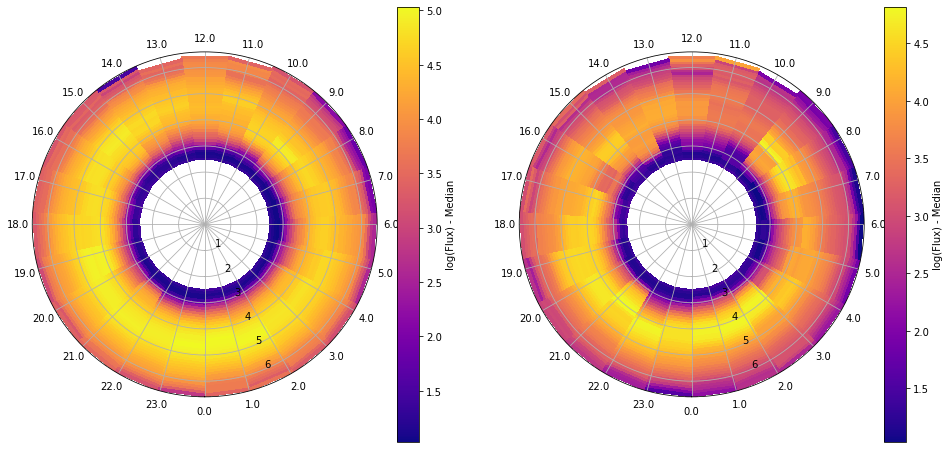

In [64]:
fig = plt.figure(figsize=(16,8))


ax = fig.add_subplot(121, projection='polar')
ax.set_theta_offset(np.pi*3/2)
plt.pcolormesh(th, r, binFluxMedian, cmap=cm2)
plt.plot(azm, r, ls='none')
plt.grid()
plt.thetagrids([theta * 15 for theta in range(360//15)], labels=mltArray)
plt.colorbar(aspect=20, fraction=0.1, label='log(Flux) - Median')

ax = fig.add_subplot(122, projection='polar')
ax.set_theta_offset(np.pi*3/2)
plt.pcolormesh(th, r, noEnhBinFluxMedian, cmap=cm2)
plt.plot(azm, r, ls='none')
plt.grid()
plt.thetagrids([theta * 15 for theta in range(360//15)], labels=mltArray)
plt.colorbar(aspect=20, fraction=0.1, label='log(Flux) - Median')
plt.show()


In [65]:
MLTassymetryNoEnh = np.zeros(len(lArray))

for l in range(len(lArray)):
    MLTassymetryNoEnh[l] = np.nanmax(noEnhBinFluxMedian[:,l])/np.nanmin(noEnhBinFluxMedian[:,l])

In [66]:
np.nanmax(noEnhBinFluxMedian, axis=0)

array([1.54965062, 1.37732425, 1.45440272, 2.0035362 , 2.54379488,
       2.86541279, 3.43894839, 3.83871282, 4.15312285, 4.36495386,
       4.48664167, 4.60412391, 4.71216699, 4.7627991 , 4.7973833 ,
       4.81417431, 4.79308103, 4.78196803, 4.76852705, 4.74756874,
       4.69458346, 4.66291023, 4.58953376, 4.51850012, 4.46491685,
       4.44607991, 4.41609353, 4.37114047, 4.27515667, 4.17894361,
       4.01863791, 3.8367203 , 3.69722431, 3.65095321, 3.65493258,
       3.36525391, 3.41325293, 3.52756894, 3.83502931, 4.02074305,
       3.35218898, 3.12126844])

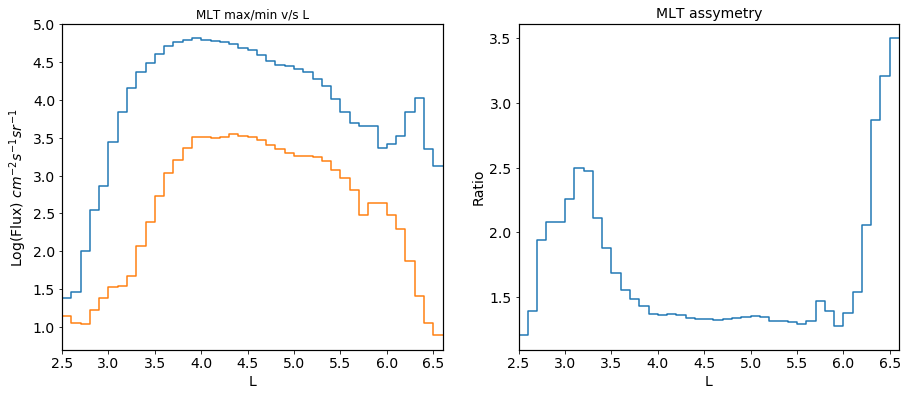

In [67]:
fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(121)
plotOptions()
plt.xlim(lArray[0],lArray[-1])

plt.ylabel('Log(Flux) $cm^{-2}s^{-1}sr^{-1}$' , fontsize='14' )
plt.xlabel('L' , fontsize='14' )
plt.title('MLT max/min v/s L')

plt.step(lArray, np.nanmax(noEnhBinFluxMedian, axis=0))
plt.step(lArray, np.nanmin(noEnhBinFluxMedian, axis=0))

ax = fig.add_subplot(122)
plotOptions()
plt.xlim(lArray[0],lArray[-1])

plt.ylabel('Ratio' , fontsize='14' )
plt.xlabel('L' , fontsize='14' )
plt.title('MLT assymetry', fontsize='14')
plt.step(lArray, MLTassymetryNoEnh)

plt.show()
